In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap#, partial
from jax import random
from jax.experimental import optimizers
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from functools import partial
from jax.config import config
import jax.lax as lax

from scipy import constants
from scipy.spatial.transform import Rotation 

from functools import partial

import itertools
from itertools import starmap
from jax.tree_util import tree_flatten, tree_unflatten

import numpy as np
import pickle
import copy
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import colorsys

from tqdm import tqdm
import time

config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)
config.parse_flags_with_absl()


%matplotlib inline

plt.rcParams["font.size"] = 18

# Functions

## main

In [2]:
def blackbody_rad(w, Temp):
    return hbar*w**3/(4*jnp.pi**3*c_light**2)/(jnp.exp(hbar*w/(k_b*Temp)) -1 )

In [3]:
def fm(e, beta, mu=jnp.array(0.0)):
    return 1.0/(1.0+jnp.exp((e-mu)*beta))

In [4]:
def calc_target_mu(e, beta, filling):
    mu_max_pre = jnp.max(e)
    mu_min_pre = jnp.min(e)
    mu = (mu_max_pre + mu_min_pre)/2
    for i in range(30):
        tmp_filling = fm(e, beta, mu=mu).sum()/n_k
        sign_mu = jnp.sign(tmp_filling - filling)
        
        mu_max = mu*(sign_mu+1)/2 + mu_max_pre * (-sign_mu+1)/2
        mu_min = mu_min_pre*(sign_mu+1)/2 +  mu * (-sign_mu+1)/2
        mu = (mu_max+mu_min)/2

        mu_max_pre = mu_max
        mu_min_pre = mu_min
    return mu

In [5]:
def vmap_calc_opdhdk1(k, hc):
    f = partial(calc_ham_k, hc=hc)
    return jax.vmap(jax.jacfwd(f))(k) 

def vmap_calc_opdhdk2(k, hc):
    f = partial(calc_ham_k, hc=hc)
    return jax.vmap(jax.jacfwd(jax.jacfwd(f)))(k) 

def vmap_calc_opdhdk3(k, hc):
    f = partial(calc_ham_k, hc=hc)
    return jax.vmap(jax.jacfwd(jax.jacfwd(jax.jacfwd(f))))(k) 

In [6]:
def vmap_calc_ham(k, hc):
    f = partial(calc_ham_k, hc=hc)
    return jax.vmap(f)(k) 

In [7]:
def calc_PVE_k(e_k, v_k, A_k, B_k, C_k, w, beta, gamma, mu):
    """
    Calculate the value of Photoboltaic Effect at each k point using second-order respose theory. 
    see Eq. (5) and (9-12) in https://doi.org/10.1103/PhysRevB.104.L180407 (or https://arxiv.org/abs/2108.00674) for detail. 
    """
    
    fm_k = fm(e_k, beta, mu)
    fm_diff_k = fm_k.reshape(2*N, 1) - fm_k.reshape(1, 2*N)
    e_diff_k = (e_k.reshape(2*N, 1) - e_k.reshape(1, 2*N))/hbar
    
    PVE_1_k = -ec**3*(fm_k*jnp.diagonal(C_k)).sum()/(hbar*w)**2
    PVE_2_k = -ec**3*(fm_diff_k*A_k*B_k.T/(w+1j*gamma-e_diff_k) + fm_diff_k*A_k*B_k.T/(-w+1j*gamma-e_diff_k)).sum()/(hbar*w)**2
    PVE_3_k = -ec**3*(fm_diff_k*B_k*A_k.T/(1j*gamma - e_diff_k)).sum()/(hbar*w)**2
    
    A_k_ab = A_k.reshape(2*N, 2*N, 1)
    A_k_bc = A_k.reshape(1, 2*N, 2*N)
    A_k_ca = A_k.T.reshape(2*N, 1, 2*N)

    fm_diff_k_ab = fm_diff_k.reshape(2*N, 2*N, 1)
    fm_diff_k_cb = fm_diff_k.T.reshape(1, 2*N, 2*N)

    e_diff_k_ba = e_diff_k.T.reshape(2*N, 2*N, 1)
    e_diff_k_cb = e_diff_k.T.reshape(1, 2*N, 2*N)
    e_diff_k_ca = e_diff_k.T.reshape(2*N, 1, 2*N)
    
    PVE_4_k = -ec**3*(A_k_ab*A_k_bc*A_k_ca/(1j*gamma-e_diff_k_ca) * \
             (fm_diff_k_ab/( w+1j*gamma-e_diff_k_ba) + fm_diff_k_cb/( w+1j*gamma-e_diff_k_cb) + \
              fm_diff_k_ab/(-w+1j*gamma-e_diff_k_ba) + fm_diff_k_cb/(-w+1j*gamma-e_diff_k_cb))).sum()/(hbar*w)**2
    
    return PVE_1_k, PVE_2_k, PVE_3_k, PVE_4_k

In [8]:
def vmap_calc_PVE_w(w, e, v, A ,B, C, beta, gamma, mu=jnp.array(0.0)):
    f = partial(calc_PVE_k, w=w, beta=beta, gamma=gamma, mu=mu)
    PVE_1_w, PVE_2_w, PVE_3_w, PVE_4_w = jax.vmap(f)(e, v, A, B, C) 
    factor_norm = K*K_xy**2/((2*jnp.pi)**3*n_k)
    return PVE_1_w.sum()*factor_norm, PVE_2_w.sum()*factor_norm, PVE_3_w.sum()*factor_norm, PVE_4_w.sum()*factor_norm

In [9]:
@jit
def vmap_calc_PVE(ws, e, v, A ,B, C, beta, gamma, mu=jnp.array(0.0)):
    f = partial(vmap_calc_PVE_w, e=e, v=v, A=A ,B=B, C=C, beta=beta, gamma=gamma, mu=mu)
    return jax.vmap(f)(ws)

In [10]:
def calc_SJt(params, hc_cond):
    theta_S = jnp.pi*jax.nn.sigmoid(params[:N])
    phi_S = params[N:2*N]
    Sx = jnp.sin(theta_S)*jnp.cos(phi_S)
    Sy = jnp.sin(theta_S)*jnp.sin(phi_S)
    Sz = jnp.cos(theta_S)
    
    t0 = hc_cond['t0_max']*jnp.tanh(params[2*N:3*N])*ec

    _ind = 3*N
    J_S = jax.nn.softplus(params[_ind:_ind+1])*ec
    
    t_max = hc_cond['t_max']

    t_abs = t_max*jax.nn.sigmoid(params[_ind+1:_ind+2])
    theta_t = hc_cond['theta_t_max']*jnp.tanh(params[_ind+2:_ind+3]) # t1が最大になるように。
    phi_t = hc_cond['phi_t_max']*params[_ind+3:_ind+4] # !!!!!!!!!!!!!!!!!!!!!!!!!!0に固定
    
    phase_t1 = params[_ind+4:_ind+5]*hc_cond['soc_t1_on']
    phase_t2 = params[_ind+5:_ind+6]*hc_cond['soc_t2_on']
    phase_t3 = params[_ind+6:_ind+7]*hc_cond['soc_t3_on']
    
    t1 = -t_abs * hc_cond['t1_coeff'] * jnp.cos(theta_t)*jnp.exp(1j*phase_t1) # t1 is negative when theta_t=0
    t2 =  t_abs * hc_cond['t2_coeff'] * jnp.sin(theta_t)*jnp.cos(phi_t)*jnp.exp(1j*phase_t2)
    t3 =  t_abs * hc_cond['t3_coeff'] * jnp.sin(theta_t)*jnp.sin(phi_t)*jnp.exp(1j*phase_t3)
    t123 = jnp.concatenate([t1,t2,t3])*ec

    hc = {'Sx': Sx, 'Sy': Sy, 'Sz': Sz, 'J_S': J_S, 't0': t0, 't': t123}
    
    return hc

In [11]:
def calc_ham_k(k_i, hc):
    ham_k = jnp.zeros((2*N, 2*N), dtype=jnp.complex128)
    
    i_s = jnp.arange(N)

    ham_k = jax.ops.index_add(ham_k, jax.ops.index[(i_s+1)%N, i_s],  hc['t'][0]*jnp.exp(-1j*a_z*k_i) )
    ham_k = jax.ops.index_add(ham_k, jax.ops.index[i_s, (i_s+1)%N], (hc['t'][0]*jnp.exp(-1j*a_z*k_i)).conj() )
    ham_k = jax.ops.index_add(ham_k, jax.ops.index[(i_s+2)%N, i_s],  hc['t'][1]*jnp.exp(-1j*2*a_z*k_i) )
    ham_k = jax.ops.index_add(ham_k, jax.ops.index[i_s, (i_s+2)%N], (hc['t'][1]*jnp.exp(-1j*2*a_z*k_i)).conj() )
    ham_k = jax.ops.index_add(ham_k, jax.ops.index[(i_s+3)%N, i_s],  hc['t'][2]*jnp.exp(-1j*3*a_z*k_i) )
    ham_k = jax.ops.index_add(ham_k, jax.ops.index[i_s, (i_s+3)%N], (hc['t'][2]*jnp.exp(-1j*3*a_z*k_i)).conj() )

    ham_k = jax.ops.index_add(ham_k, jax.ops.index[N+(i_s+1)%N, N+i_s],  hc['t'][0].conj()*jnp.exp(-1j*a_z*k_i) )
    ham_k = jax.ops.index_add(ham_k, jax.ops.index[N+i_s, N+(i_s+1)%N], (hc['t'][0].conj()*jnp.exp(-1j*a_z*k_i)).conj() )
    ham_k = jax.ops.index_add(ham_k, jax.ops.index[N+(i_s+2)%N, N+i_s],  hc['t'][1].conj()*jnp.exp(-1j*2*a_z*k_i) )
    ham_k = jax.ops.index_add(ham_k, jax.ops.index[N+i_s, N+(i_s+2)%N], (hc['t'][1].conj()*jnp.exp(-1j*2*a_z*k_i)).conj() )
    ham_k = jax.ops.index_add(ham_k, jax.ops.index[N+(i_s+3)%N, N+i_s],  hc['t'][2].conj()*jnp.exp(-1j*3*a_z*k_i) )
    ham_k = jax.ops.index_add(ham_k, jax.ops.index[N+i_s, N+(i_s+3)%N], (hc['t'][2].conj()*jnp.exp(-1j*3*a_z*k_i)).conj() )

    ham_k = jax.ops.index_add(ham_k, jax.ops.index[i_s, i_s],       hc['J_S']*hc['Sz']+hc['t0'])
    ham_k = jax.ops.index_add(ham_k, jax.ops.index[i_s+N, i_s+N],  -hc['J_S']*hc['Sz']+hc['t0'])
    ham_k = jax.ops.index_add(ham_k, jax.ops.index[i_s, N+i_s],  hc['J_S']*(hc['Sx']-1j*hc['Sy']))
    ham_k = jax.ops.index_add(ham_k, jax.ops.index[N+i_s, i_s],  hc['J_S']*(hc['Sx']+1j*hc['Sy']))
    
    return ham_k

In [12]:
def flow(params, k, ws, beta, filling, gamma, blackbody_rad_modified, hc_cond):
    hc = calc_SJt(params, hc_cond)
    ham = vmap_calc_ham(k, hc)
    e, v = jnp.linalg.eigh(ham)
    mu = calc_target_mu(e, beta, filling)

    dhamdk1 = vmap_calc_opdhdk1(k, hc)
    dhamdk2 = vmap_calc_opdhdk2(k, hc)
    dhamdk3 = vmap_calc_opdhdk3(k, hc)

    A = v.transpose(0,2,1).conj()@dhamdk1@v/hbar
    B = v.transpose(0,2,1).conj()@dhamdk2@v/hbar
    C = v.transpose(0,2,1).conj()@dhamdk3@v/hbar

    PVE_1, PVE_2, PVE_3, PVE_4 = vmap_calc_PVE(ws, e, v, A ,B, C, beta, gamma, mu)

    Current = jnp.trapz((PVE_1+PVE_2+PVE_3+PVE_4).real*blackbody_rad_modified, ws)
    
    return -Current, (PVE_1, PVE_2, PVE_3, PVE_4, e, mu, hc)

In [13]:
@jit
def train(xs, params_init, k, ws, filling, blackbody_rad_modified, dic_opt, hc_cond):
    func_step_size = optimizers.piecewise_constant(dic_opt['step_loops'], dic_opt['step_sizes'])
    opt_init, opt_update, get_params = optimizers.rmsprop(func_step_size, gamma=0.99)
    opt_state = opt_init(params_init)
    def one_loop(opt_state, x):
        step, gamma, beta = x['step'], x['gamma'], x['beta']
        func = partial(flow, k=k, ws=ws, beta=beta, filling=filling, gamma=gamma, blackbody_rad_modified=blackbody_rad_modified, hc_cond=hc_cond)
        params = get_params(opt_state)
        values, grads = jax.value_and_grad(func, argnums=0, has_aux=True)(params)
        opt_state = opt_update(step, grads, opt_state)
        dic_out = {'param': get_params(opt_state), 'Current': values[0], 'grads': grads, 'beta': beta, 'gamma': gamma}
        dic_out.update(calc_intermed_states(values[1], beta))
        
        return opt_state, dic_out
    state_end, logger = lax.scan(one_loop, opt_state, xs)
    return state_end, logger

## setup

In [14]:
def get_initial(seed=111):
    key = random.PRNGKey(seed)
    theta_S = random.uniform(key, (N,), minval=-1, maxval=1) # apply sigmoid later
    key, subkey = jax.random.split(key)
    phi_S = random.uniform(key, (N,), minval=-jnp.pi, maxval=jnp.pi)
    key, subkey = jax.random.split(key)
    t0 = random.uniform(key, (N,), minval=-0.1, maxval=0.1)
    key, subkey = jax.random.split(key)
    J_S = random.uniform(key, (1,), minval=0, maxval=0.5)
    key, subkey = jax.random.split(key)
    t_base = random.uniform(key, (6,), minval=-1, maxval=1) # for t2 and t3. apply tanh later
    t_base = t_base * jnp.array([1.0,1.0,jnp.pi,jnp.pi,jnp.pi,jnp.pi])

    params = jnp.concatenate([theta_S, phi_S, t0, J_S, t_base])
    
    return params

## logging

In [15]:
def cat_logger(logger1, logger2):
    logger2_copy = copy.copy(logger2)
    if logger1 == {}:
        return logger2_copy
    else:
        logger1_flat, logger1_tree = tree_flatten(logger1)
        logger2_flat, logger2_tree = tree_flatten(logger2)
        logger_new_flat = list(starmap(lambda v1, v2: jnp.concatenate([v1, v2]), zip(logger1_flat, logger2_flat)))
        logger_new = tree_unflatten(logger1_tree, logger_new_flat)
        
        return logger_new

In [16]:
def calc_gaps(e):
    gaps = jnp.array([e[:,i+1].min() - e[:,i].max() for i in range(2*N-1)])
    gaps = jax.nn.relu(gaps)
    
    e_diff = e[:,1:] - e[:,:-1]
    gaps_direct = jnp.min(e_diff, axis=(0,))
    return gaps, gaps_direct

In [17]:
def calc_intermed_states(aux, beta):
    PVE_1, PVE_2, PVE_3, PVE_4, e, mu, hc = aux
    N_k = jnp.array(e.shape[:-1]).prod()
    gaps, gaps_direct = calc_gaps(e)

    n_fill = fm(e, beta, mu).sum()/N_k
    e_tot = (fm(e, beta, mu)*e).sum()/N_k
    
    PVE = PVE_1 + PVE_2 + PVE_3 + PVE_4

    dic_state = {'mu': mu, 'e_tot': e_tot, 'n_fill': n_fill, 'gaps': gaps, 'gaps_direct': gaps_direct, 
                'PVE': PVE, 'PVE_1': PVE_1, 'PVE_2': PVE_2, 'PVE_3': PVE_3, 'PVE_4': PVE_4}
    dic_state.update(hc)
    return dic_state

In [18]:
def save_results(opt_state, logger, text_condition, seed):
    t_traind = optimizers.unpack_optimizer_state(opt_state)
    filename = f'result/opt_state_{text_condition}_seed{seed}.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(t_traind, file)

    filename = f'result/logger_{text_condition}_seed{seed}.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(logger, file)
    print(f'if you want to load this: \nopt_state, logger = load_results(\'{text_condition}\',{seed}) \nparams = get_params(opt_state)')
    
def load_results(text_condition, seed):
    filename = f'result/opt_state_{text_condition}_seed{seed}.pkl'
    with open(filename, 'rb') as file:
        t_traind = pickle.load(file)
    opt_state = optimizers.pack_optimizer_state(t_traind)

    filename = f'result/logger_{text_condition}_seed{seed}.pkl'
    with open(filename, 'rb') as file:
        logger = pickle.load(file)

    return opt_state, logger

In [19]:
def rotate_S(hc):
    S_tot = jnp.array([hc['Sx'].mean(), hc['Sy'].mean(), hc['Sz'].mean()])
    S_tot = S_tot/np.linalg.norm(S_tot)
    e_z = jnp.array([0,0,1])
    
    rotvec = jnp.cross(S_tot, e_z)
    rotvec = np.array(rotvec)
    
    rotval = np.arccos(np.inner(S_tot, e_z))
    rotvec = rotval*rotvec/np.linalg.norm(rotvec)
    
    rot = Rotation.from_rotvec(rotvec)
    
    _S = jnp.array([hc['Sx'], hc['Sy'], hc['Sz']])
    S_modified = rot.apply(_S.T)
    
    return S_modified

## plot

In [20]:
def calc_results(params, k, ws, beta, filling, gamma, blackbody_rad_modified, hc_cond):
    hc = calc_SJt(params, hc_cond)
    ham = vmap_calc_ham(k, hc)
    e, v = jnp.linalg.eigh(ham)
    mu = calc_target_mu(e, beta, filling)

    dhamdk1 = vmap_calc_opdhdk1(k, hc)
    dhamdk2 = vmap_calc_opdhdk2(k, hc)
    dhamdk3 = vmap_calc_opdhdk3(k, hc)

    A = v.transpose(0,2,1).conj()@dhamdk1@v/hbar
    B = v.transpose(0,2,1).conj()@dhamdk2@v/hbar
    C = v.transpose(0,2,1).conj()@dhamdk3@v/hbar

    PVE_1, PVE_2, PVE_3, PVE_4 = vmap_calc_PVE(ws, e, v, A ,B, C, beta, gamma, mu)
    Current = jnp.trapz((PVE_1+PVE_2+PVE_3+PVE_4).real*blackbody_rad_modified, ws)
    S_modified = rotate_S(hc)

    return hc, e, v, mu, ws, PVE_1, PVE_2, PVE_3, PVE_4, Current, S_modified

In [21]:
def plot_logger(logger, blackbody_rad_modified):
    plt.rcParams["font.size"] = 18

    fig, axes = plt.subplots(3,4, figsize=(24,18), sharex=True)
    ax = axes[0][0]
    ax.plot(logger['Current'])
    ax.set_title(r'-Current [$A/m^2$]')

    ax = axes[0][1]    
    ax.plot(jnp.trapz(logger['PVE_1'].real*blackbody_rad_modified, ws, axis=1), label='Current_1')
    ax.plot(jnp.trapz(logger['PVE_2'].real*blackbody_rad_modified, ws, axis=1), label='Current_2')
    ax.plot(jnp.trapz(logger['PVE_3'].real*blackbody_rad_modified, ws, axis=1), label='Current_3')
    ax.plot(jnp.trapz(logger['PVE_4'].real*blackbody_rad_modified, ws, axis=1), label='Current_4')
    ax.set_title('Current_i')    

    ax = axes[0][2]   
    i_peak = jnp.argmax(blackbody_rad_modified)
    ax.plot(logger['PVE_1'][:,i_peak].real, label='PVE_1 peak')
    ax.plot(logger['PVE_2'][:,i_peak].real, label='PVE_2 peak')
    ax.plot(logger['PVE_3'][:,i_peak].real, label='PVE_3 peak')
    ax.plot(logger['PVE_4'][:,i_peak].real, label='PVE_4 peak')
    ax.set_title('PVE peak ')    

    
    ax = axes[0][3]
    grads_norm = jnp.linalg.norm(logger['grads'], axis=1)
    ax.plot(grads_norm)
    ax.set_title('grads_norm')    
    
    ax = axes[1][0]
    ax.plot(logger['gaps']/ec, label=list(range(2*N-1)), alpha=0.5)
    ax.axhline(y=0.0, xmin=0.0, xmax=1.0, color='black')
    ax.set_title('gap [ev]')

    ax = axes[1][1]
    ax.plot(logger['gaps_direct']/ec, label=list(range(2*N-1)), alpha=0.5)
    ax.axhline(y=0.0, xmin=0.0, xmax=1.0, color='black')
    ax.set_title('direct gap [ev]')

    ax = axes[1][2]
    ax.plot(logger['n_fill'])
    ax.set_title(r'$n_{fill}$')    

    ax = axes[1][3]
    ax.plot(logger['e_tot']/ec)
    ax.set_title(r'$E_{tot}$ [ev]')    
    
    ax = axes[2][0]
    ax.plot(logger['beta']*ec, alpha=0.5)
    ax.set_title('beta [1/eV]')

    ax = axes[2][1]
    ax.plot(logger['gamma'], alpha=0.5)
    ax.set_title(r'gamma [2$\pi$/s]')

    plt.show()

In [22]:
def plot_JS(logger):
    plt.rcParams["font.size"] = 18
    cmap = plt.get_cmap("coolwarm")

    fig, axes = plt.subplots(2,4, figsize=(24,10))

    ax = axes[0][0]
    ax.plot(jnp.abs(logger['t'])/ec, label=['t1','t2','t3'])
    ax.legend()
    ax.set_title('|t|')

    ax = axes[0][1]
    ax.plot(jnp.angle(logger['t'])/jnp.pi, label=['t1','t2','t3'], alpha=0.7)
    ax.legend()
    ax.set_title(r'phase of t / $\pi$')

    ax = axes[0][2]
    ax.plot(logger['mu']/ec)
    ax.set_title(r'$\mu$')
    
    ax = axes[0][3]
    for i in range(N):
        ax.plot(logger['t0']/ec) # phi
    ax.set_title(r't0')

    
    ax = axes[1][0]
    for i in range(N):
        ax.plot(logger['param'][:,N+i]/jnp.pi, color=cmap(1.0*i/N)) # phi
    ax.set_title(r'$\phi / \pi$')
    
    ax = axes[1][1]
    for i in range(N):
        ax.plot(jax.nn.sigmoid(logger['param'][:, i]), color=cmap(1.0*i/N))
    ax.set_title(r'$\theta / \pi$')

    ax = axes[1][2]
    for i in range(N):
        #ax.plot(jax.nn.softplus(logger['param'][:, 2*N+i]), color=cmap(1.0*i/N))
        ax.plot(logger['J_S'][:, i]/ec, color=cmap(1.0*i/N))
    ax.set_title(r'$J$')
    
    SJ_abs = jnp.sqrt((logger['J_S']*logger['Sx']).mean(axis=1)**2 + (logger['J_S']*logger['Sy']).mean(axis=1)**2 + (logger['J_S']*logger['Sz']).mean(axis=1)**2)/ec
    ax = axes[1][3]
    ax.plot(SJ_abs)
    ax.set_title(r'$|JS|$ (total moment)')

In [23]:
def plot_JS_last(hc, S_modified):
    plt.rcParams["font.size"] = 18
    cmap = plt.get_cmap("coolwarm")
    fig, axes = plt.subplots(1,4, figsize=(24,5))
    
    _Sx = S_modified[:,0]
    _Sy = S_modified[:,1]
    _Sz = S_modified[:,2]
    ax = axes[0]
    c_max = jnp.maximum(jnp.max(jnp.abs(_Sx*hc['J_S']/ec)), jnp.max(jnp.abs(_Sy*hc['J_S']/ec)))
    ax.plot((_Sx*hc['J_S']/ec), (_Sy*hc['J_S']/ec))
    ax.scatter((_Sx*hc['J_S']/ec), (_Sy*hc['J_S']/ec), c=jnp.arange(N), cmap='coolwarm')
    ax.set_xlim(-c_max*1.1,c_max*1.1)
    ax.set_ylim(-c_max*1.1,c_max*1.1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(r'X-Y of JS')

    ax = axes[1]
    ax.plot(_Sx, _Sy)
    ax.scatter(_Sx, _Sy, c=jnp.arange(N), cmap='coolwarm')
    ax.set_title(r'X-Y of S')
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    ax = axes[2]
    ax.plot(hc['J_S']/ec, label='J [ev]')
    ax.plot((_Sz*hc['J_S'])/ec, label='Sz*J [ev]')
    ax.legend()
    
    ax = axes[3]
    ax.plot(jnp.abs(_Sz))
    ax.set_title('|Sz|')

# Caclulation

## setup

In [24]:
hbar = constants.hbar
c_light = constants.speed_of_light
k_b = constants.Boltzmann
ec = constants.elementary_charge
mu_0 = constants.mu_0
zero_celsius = constants.zero_Celsius

solar_constant = 1366.1
tmp_ws = 2.0**jnp.arange(0,60,0.0001)
sum_solar_rad = jnp.trapz(blackbody_rad(tmp_ws, 5500), tmp_ws)

In [25]:
N = 12
a_z, a_xy = 9.0*1e-10, 4.0e-10

R = N*a_z
K = 2*jnp.pi/R

K_xy = 2*jnp.pi/a_xy

n_k = 100
k = jnp.linspace(0, 1, n_k, endpoint=False)*K

ws = 2**jnp.linspace(20, jnp.log2(2e16), 200)
blackbody_rad_modified = 2*mu_0*c_light*solar_constant*blackbody_rad(ws, 5500)/sum_solar_rad

filling = jnp.array(12.0) 

In [26]:
hc_cond = {'t_max': jnp.sqrt(0.1**2*2), 't0_max': jnp.array([0.0]), 
           'theta_t_max': jnp.pi,  # jnp.arccos(1.0/jnp.sqrt(2.0)), #jnp.arccos(10.0/jnp.sqrt(101.0)), # 0 < theta_t_max < jnp.pi
           'phi_t_max': jnp.array(0.0), 
           'soc_t1_on': 0.0, 'soc_t2_on': 0.0, 'soc_t3_on': 0.0, 
           't1_coeff': 1.0, 't2_coeff': 1.0, 't3_coeff': 0.0}

## run

  0%|          | 0/1 [00:00<?, ?it/s]

if you want to load this: 
opt_state, logger = load_results('pve',1) 
params = get_params(opt_state)
300.0 1e-13 1 906.7991210028413


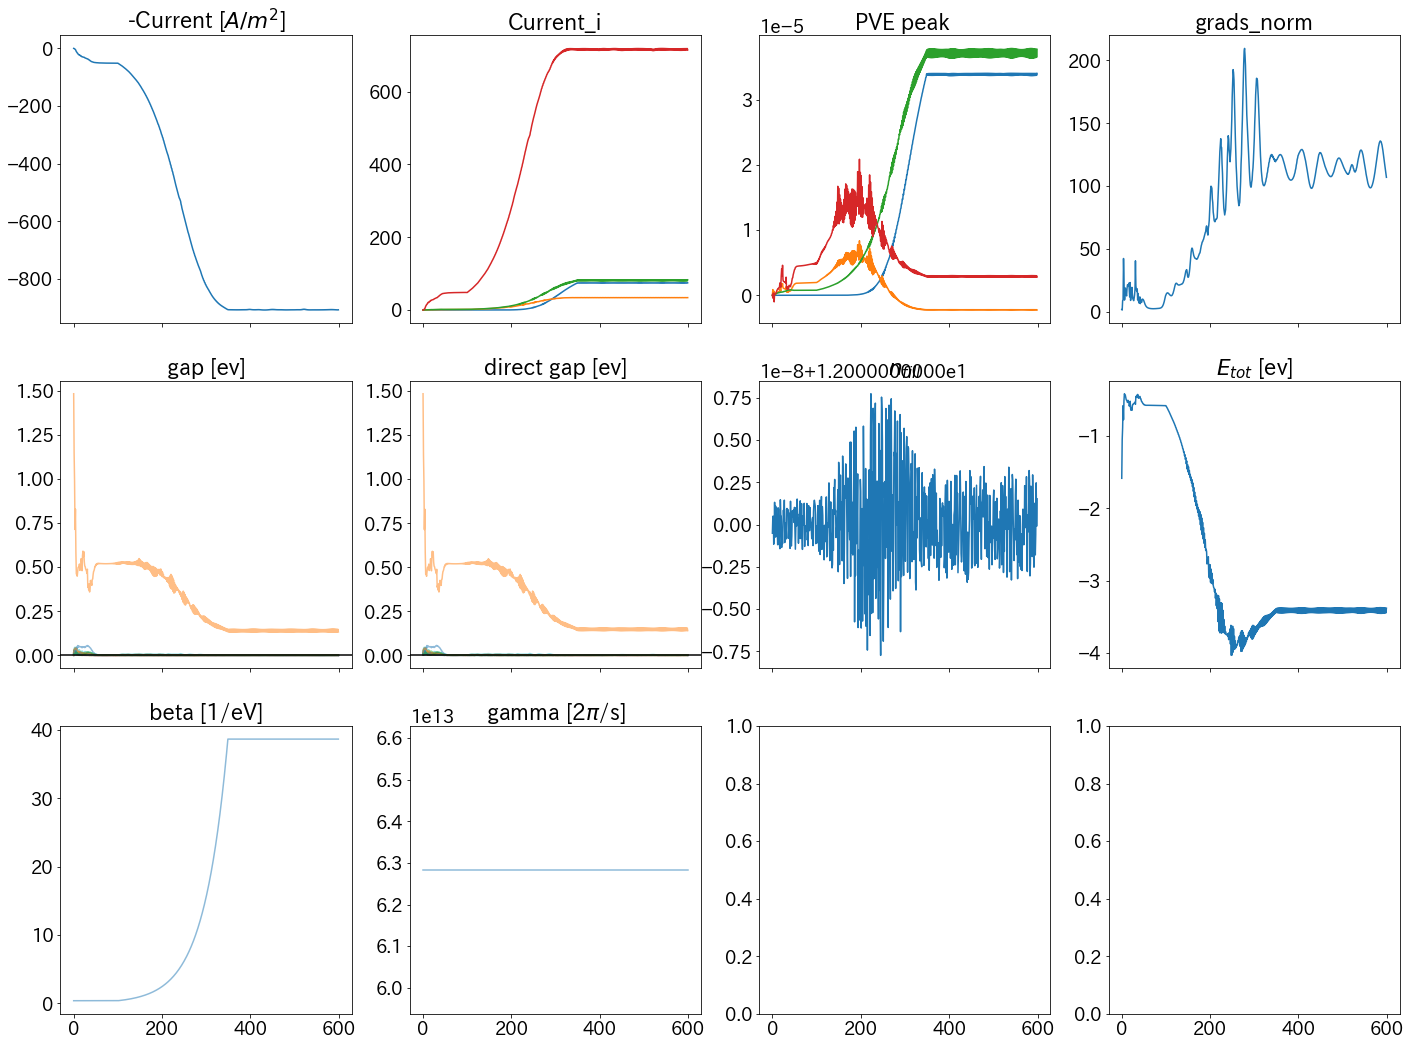

100%|██████████| 1/1 [23:56<00:00, 1436.20s/it]


CPU times: user 1h 12min 42s, sys: 1min 22s, total: 1h 14min 5s
Wall time: 23min 56s


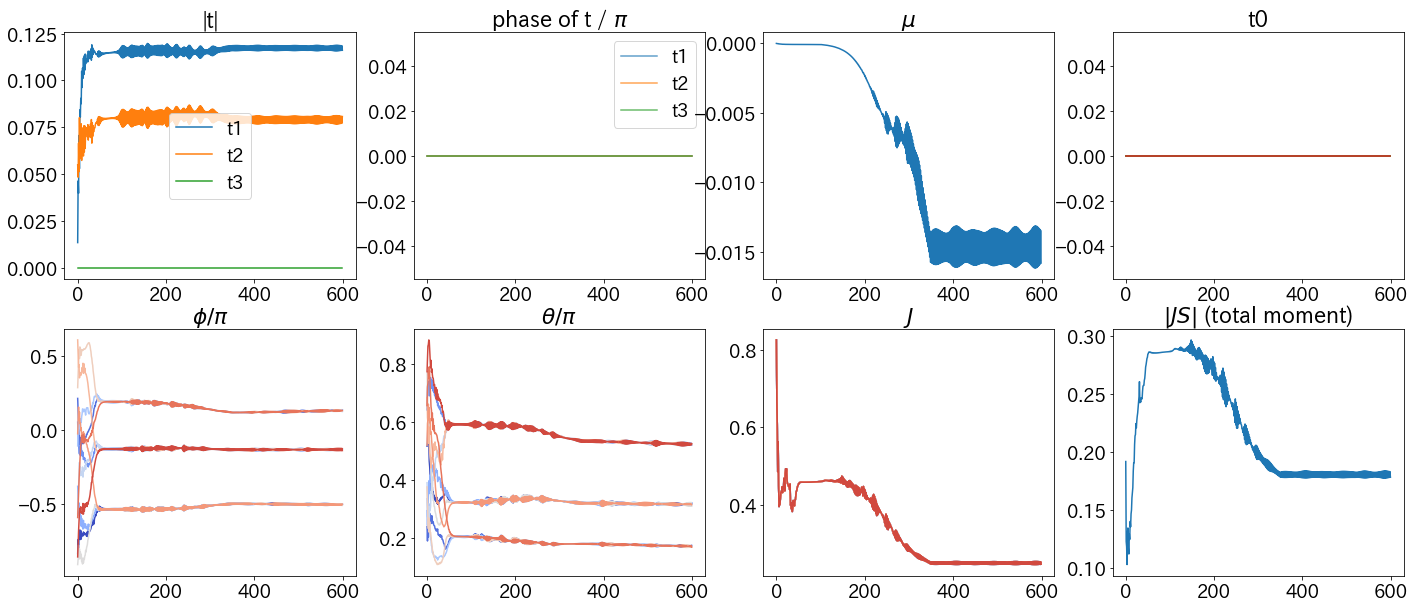

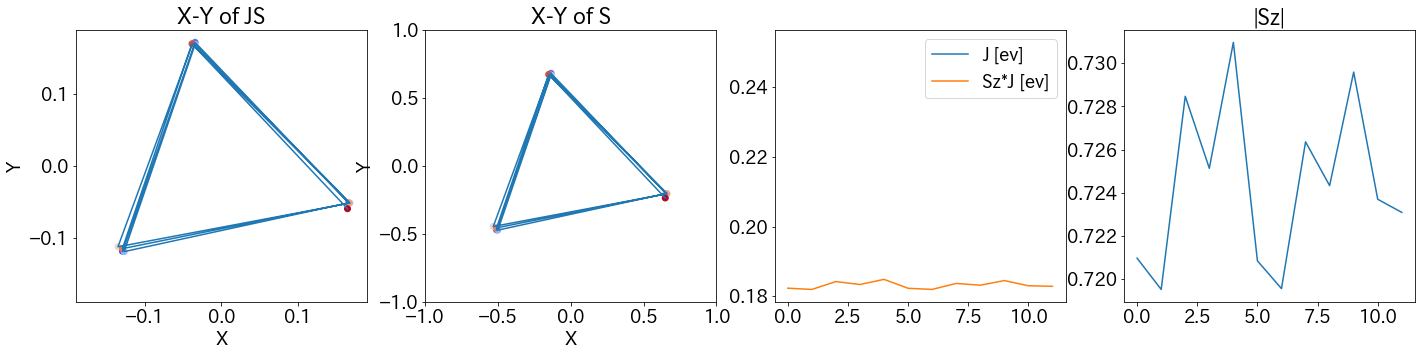

In [27]:
%%time
for seed in tqdm(range(1,2)):
    num_steps=600

    _,_, get_params = optimizers.rmsprop(0.1, gamma=0.99)
    params_init = get_initial(seed)

    logger = {}
    text_condition = f'pve'

    step_init = 0 if logger == {} else len(logger['logbeta'])
    xs = {'step': step_init + jnp.arange(num_steps)}
    temperatures = jnp.concatenate([jnp.array([30000]*100), jnp.geomspace(30000, 300, num_steps-350), jnp.array([300]*250)])
    taus = jnp.array([1e-13]*num_steps)
    xs['beta'] = jnp.array(1.0/temperatures)/k_b # 室温
    xs['gamma'] = 2*jnp.pi/(taus)

    dic_opt = {'step_loops': [], 'step_sizes': [0.03]}

    opt_state, logger_tmp = train(xs, params_init, k, ws, filling, blackbody_rad_modified, dic_opt, hc_cond)
    logger = cat_logger(logger, logger_tmp)
    params = get_params(opt_state)
    save_results(opt_state, logger, text_condition, seed)

    beta, temperature, tau, gamma = xs['beta'][-1], temperatures[-1], taus[-1], xs['gamma'][-1]
    hc, e, v, mu, ws, PVE_1, PVE_2, PVE_3, PVE_4, Current, S_modified = calc_results(params, k, ws, beta, filling, gamma, blackbody_rad_modified, hc_cond)

    print(temperature, tau, seed, Current)
    plot_logger(logger, blackbody_rad_modified)
    plot_JS(logger)
    #plot_band(k, e, v, mu)
    #plot_spin_potential(hc)
    plot_JS_last(hc, S_modified)
    #plot_PVE(PVE_1, PVE_2, PVE_3, PVE_4, blackbody_rad_modified)
    #plot_profile(params, beta, gamma, filling, hc_cond)

  0%|          | 0/8 [00:00<?, ?it/s]

if you want to load this: 
opt_state, logger = load_results('test_20220115_N12_k100_w200_T30000to300_tau1e-15_t1t2_lr0.03_600_fill12',2) 
params = get_params(opt_state)
300.0 1e-13 2 656.7562976348904


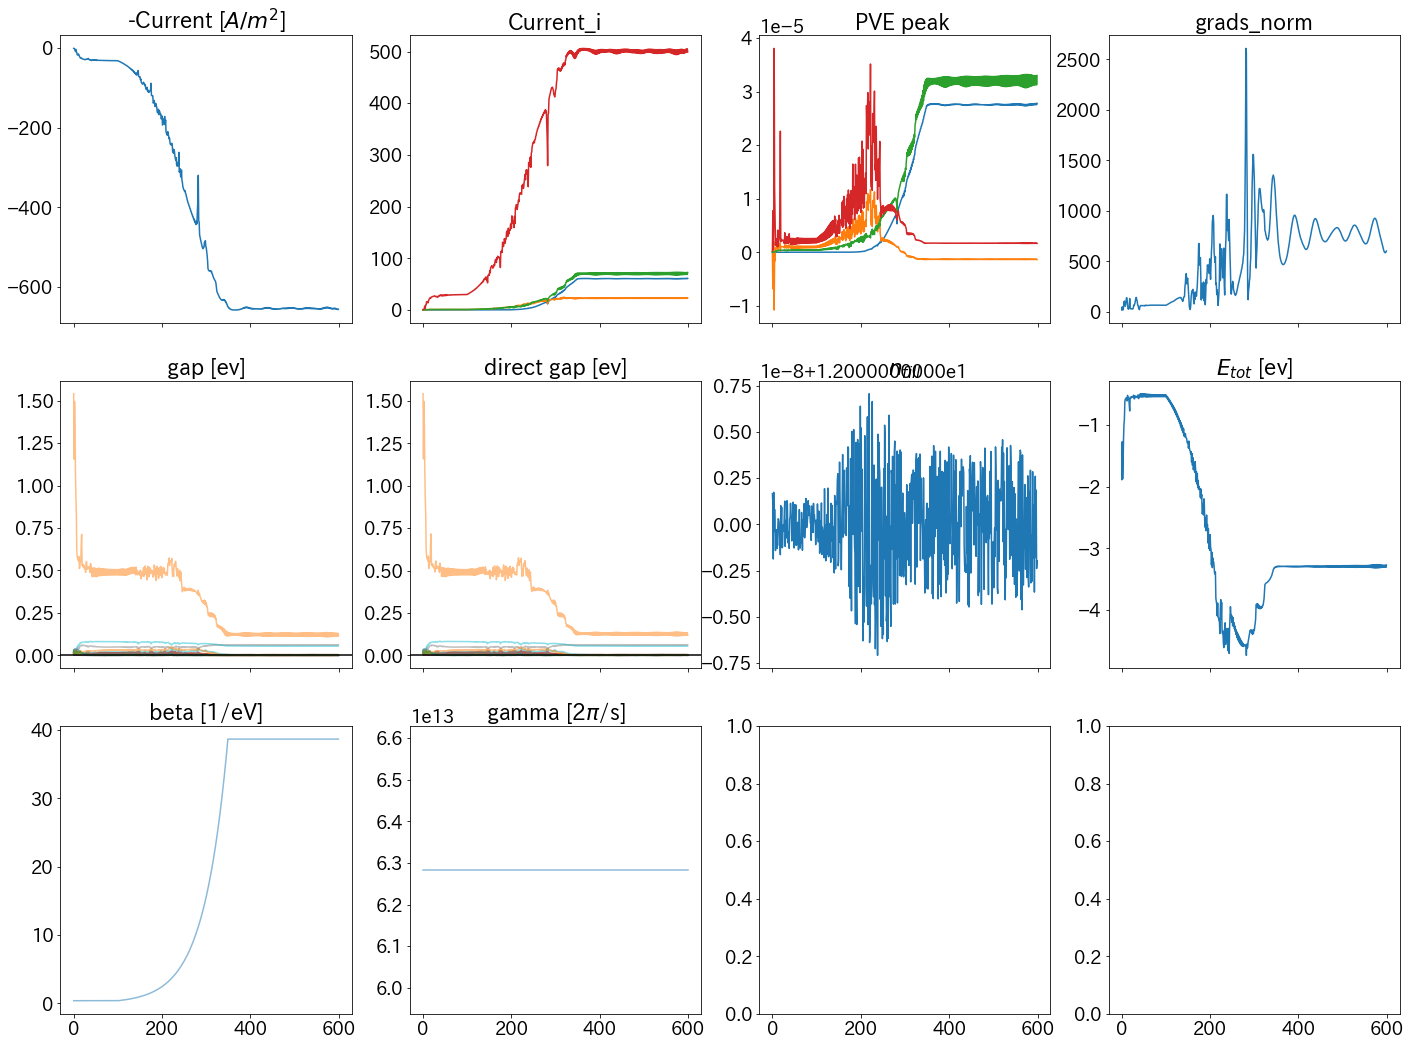

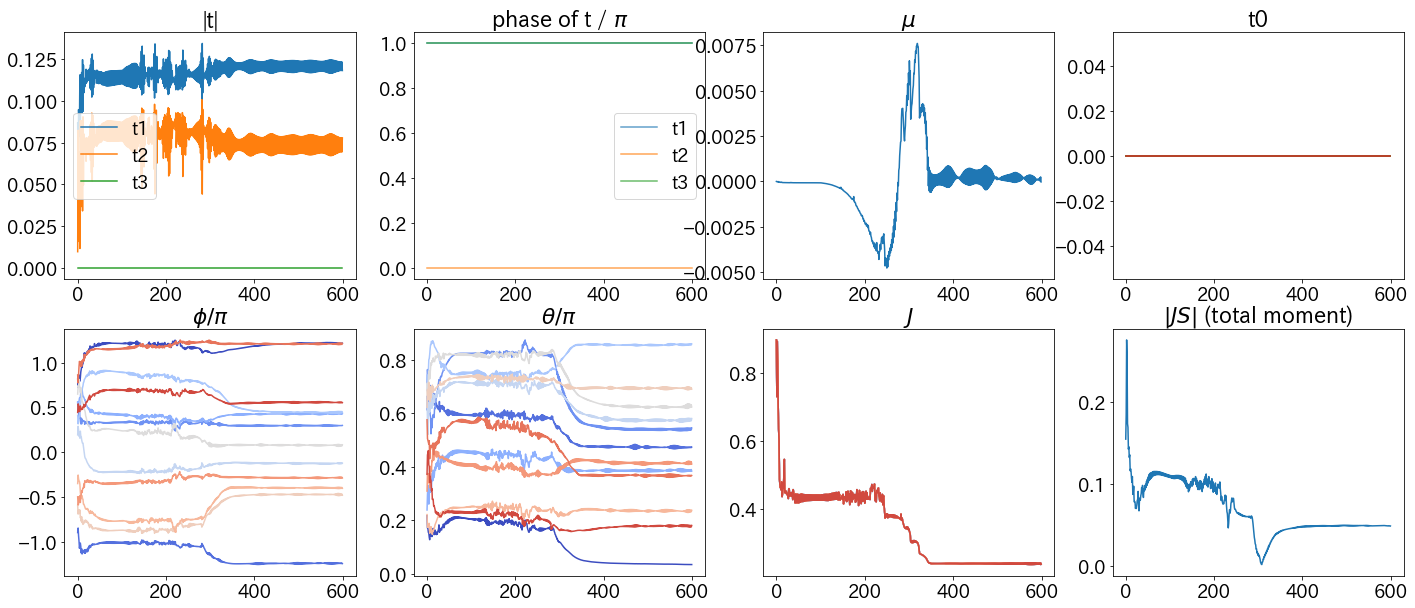

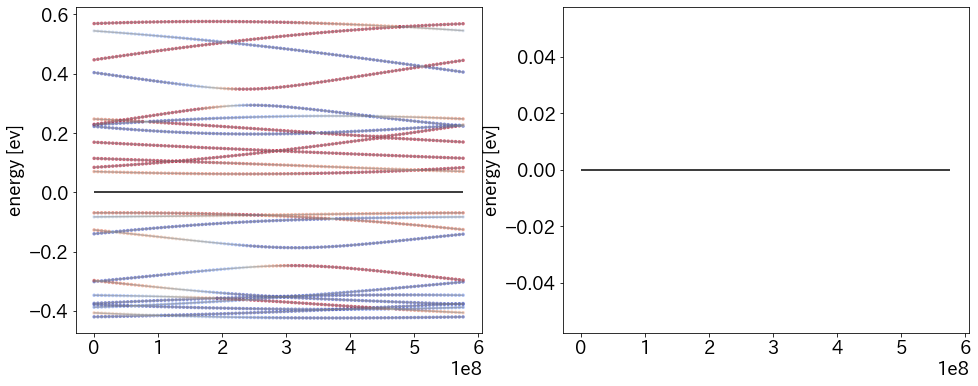

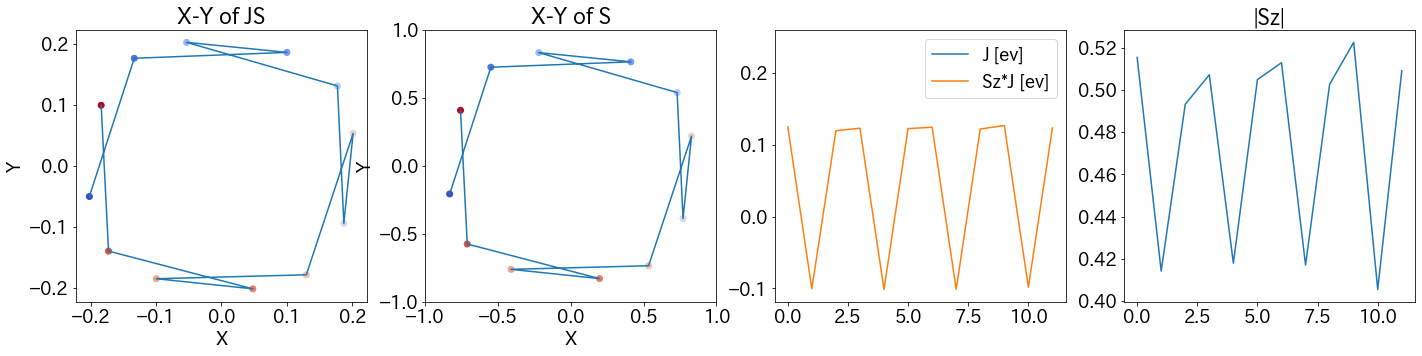

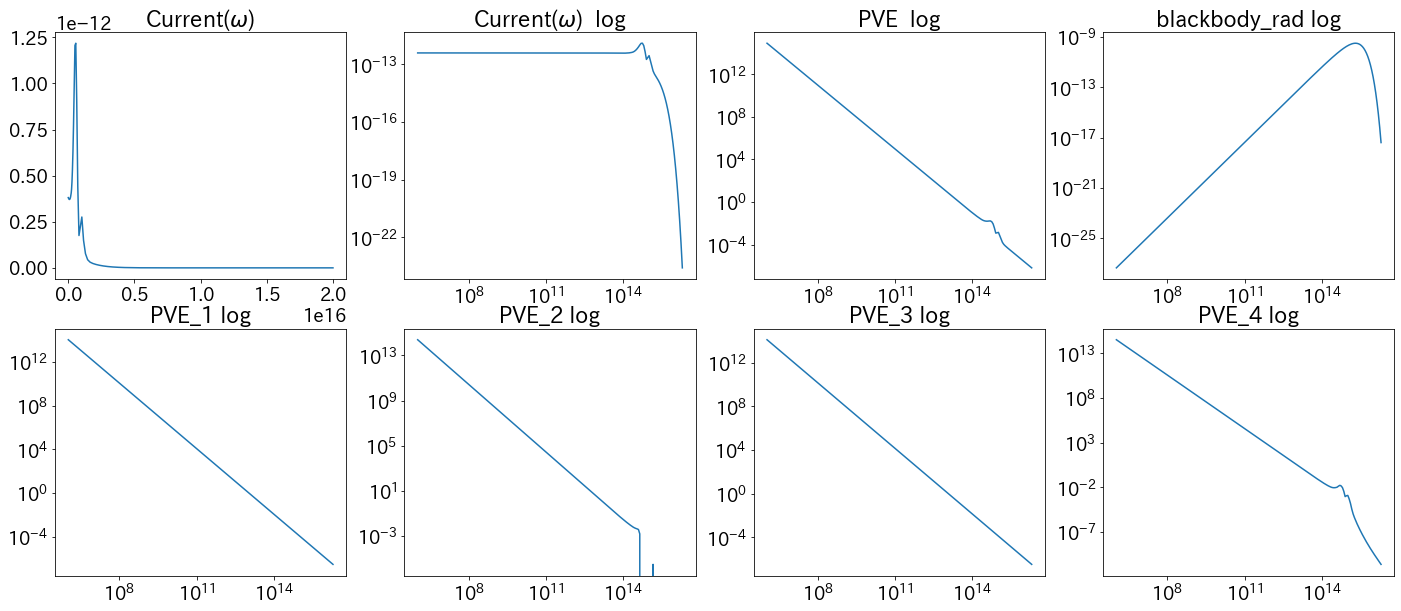

<ipython-input-22-0c15f966d3d6>:3: RuntimeWarning: invalid value encountered in log10
  tmp = np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1))
<ipython-input-22-0c15f966d3d6>:7: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(k, ws, np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1)), vmin=-15, vmax=-12, cmap='jet')
<ipython-input-22-0c15f966d3d6>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(k, ws, np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1)), vmin=-15, vmax=-12, cmap='jet')


max:-13.485399890250733, min:-25.608188275099206


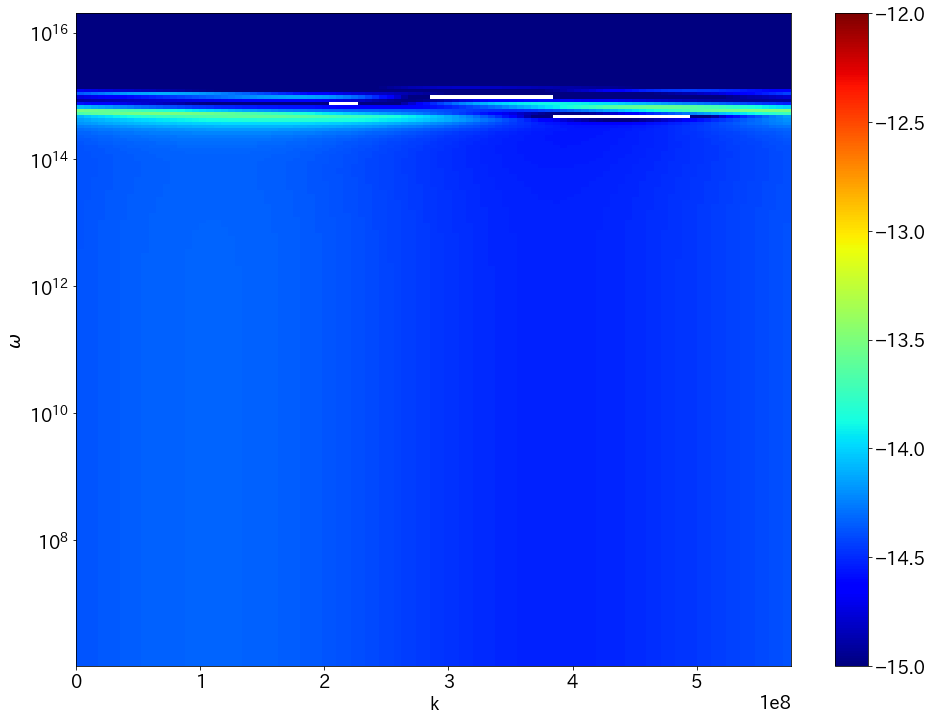

 12%|█▎        | 1/8 [20:11<2:21:23, 1211.93s/it]

if you want to load this: 
opt_state, logger = load_results('test_20220115_N12_k100_w200_T30000to300_tau1e-15_t1t2_lr0.03_600_fill12',3) 
params = get_params(opt_state)
300.0 1e-13 3 907.1062158328149


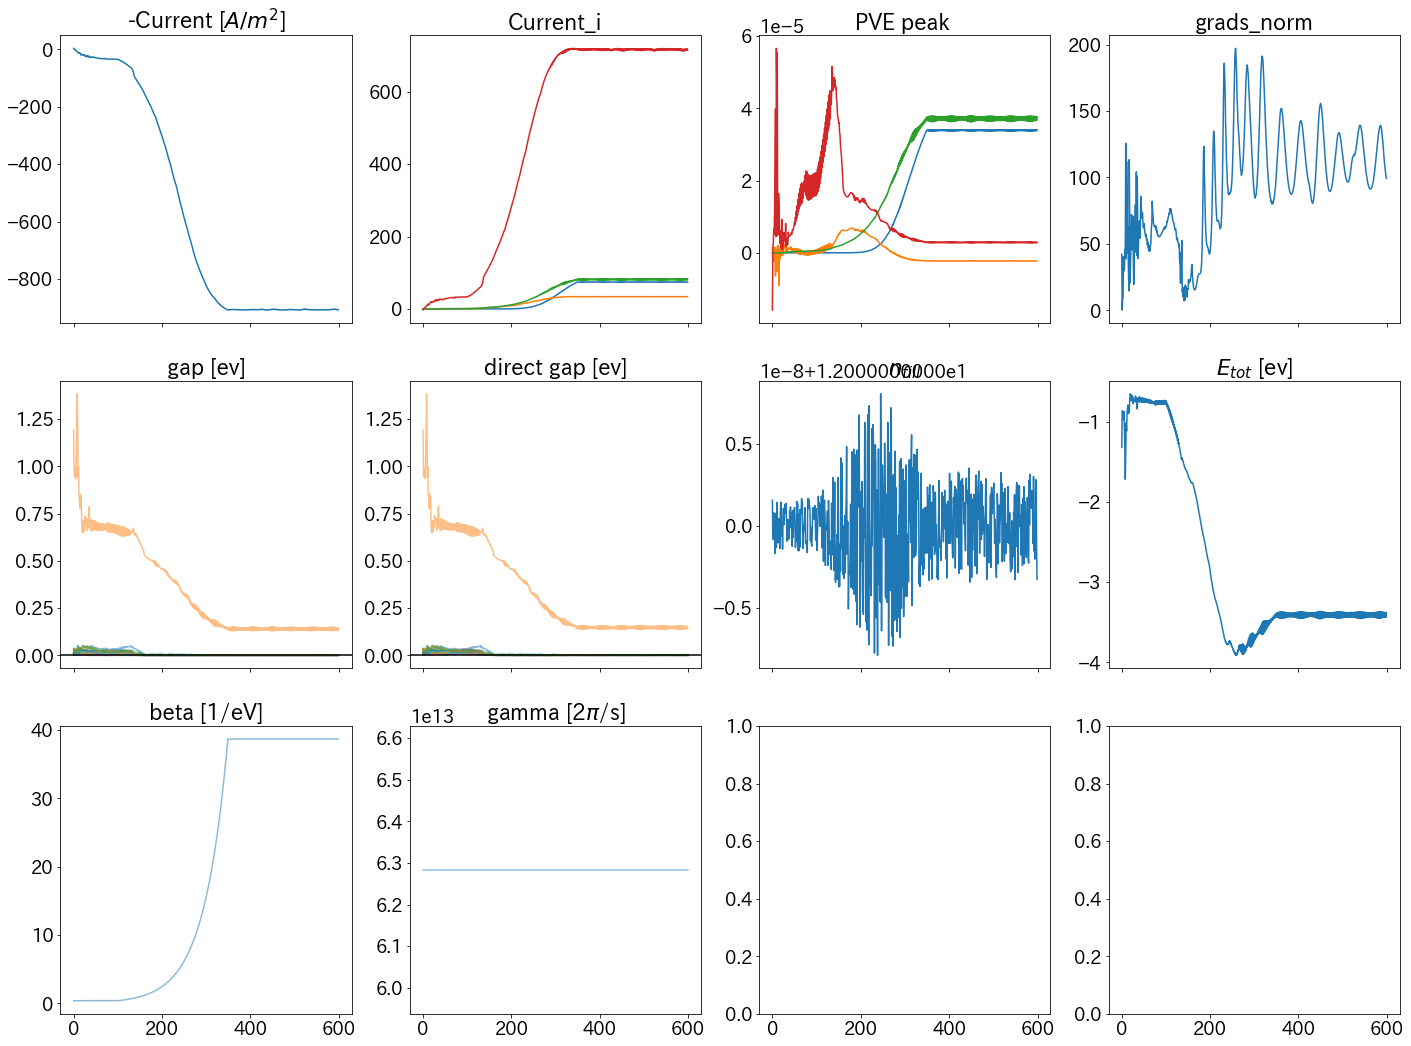

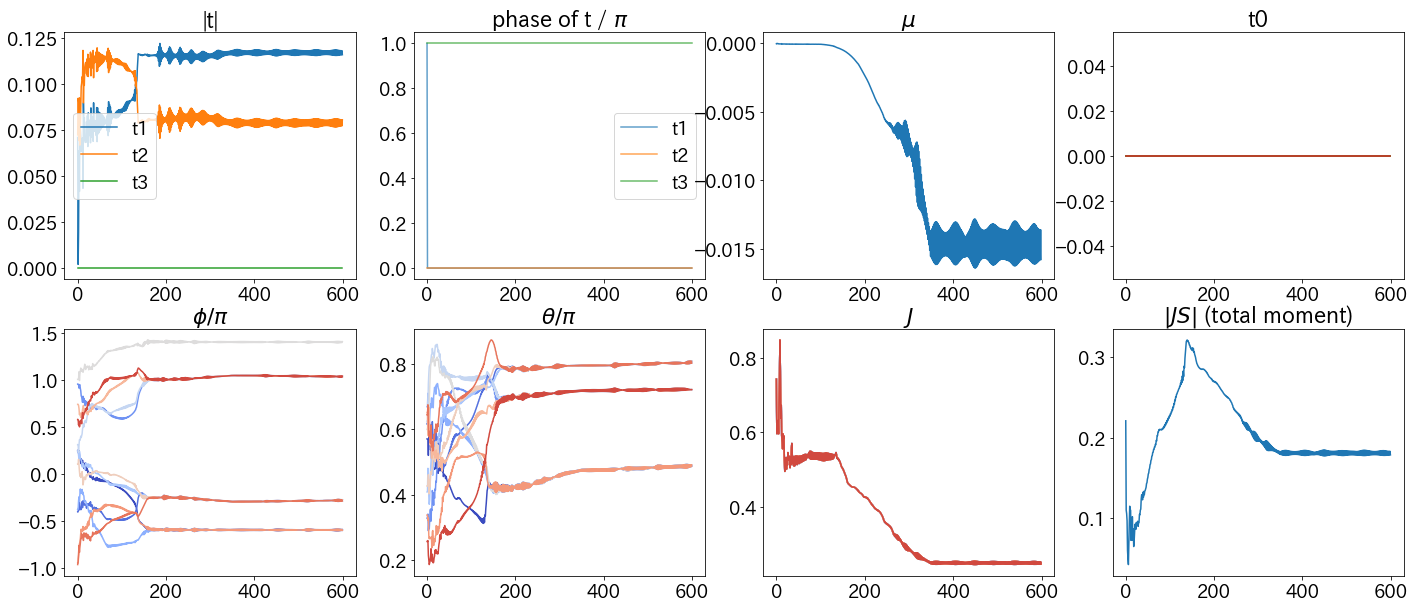

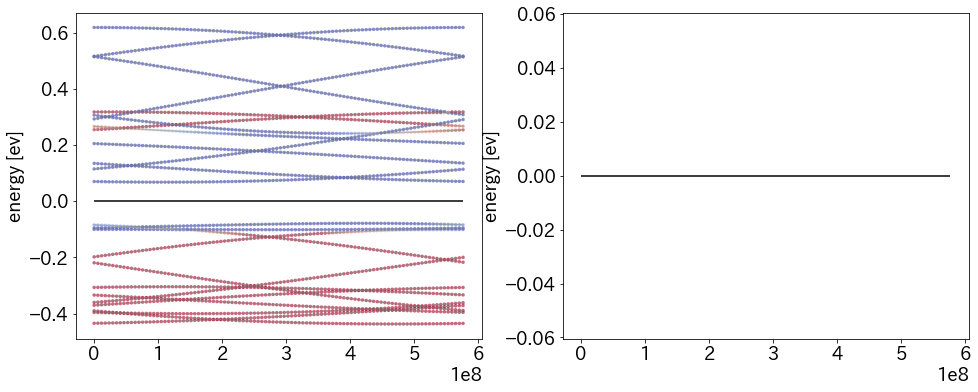

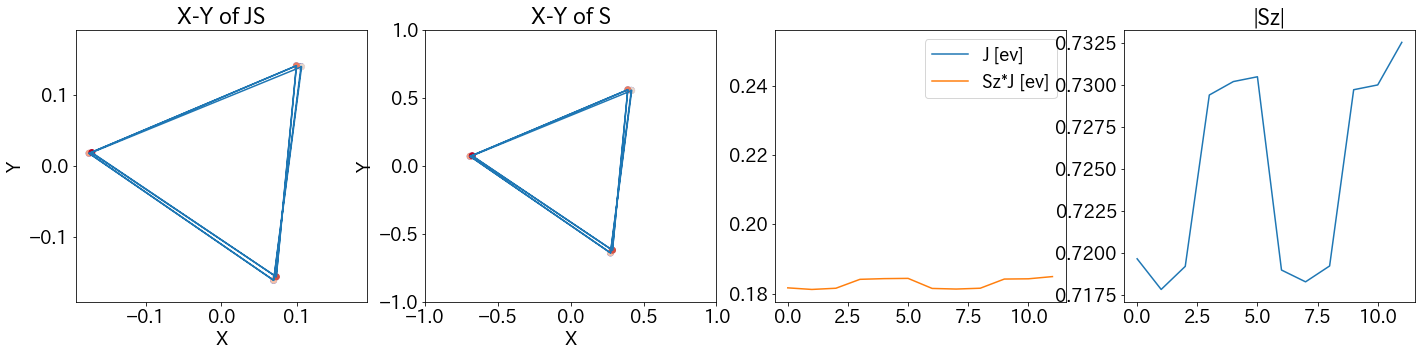

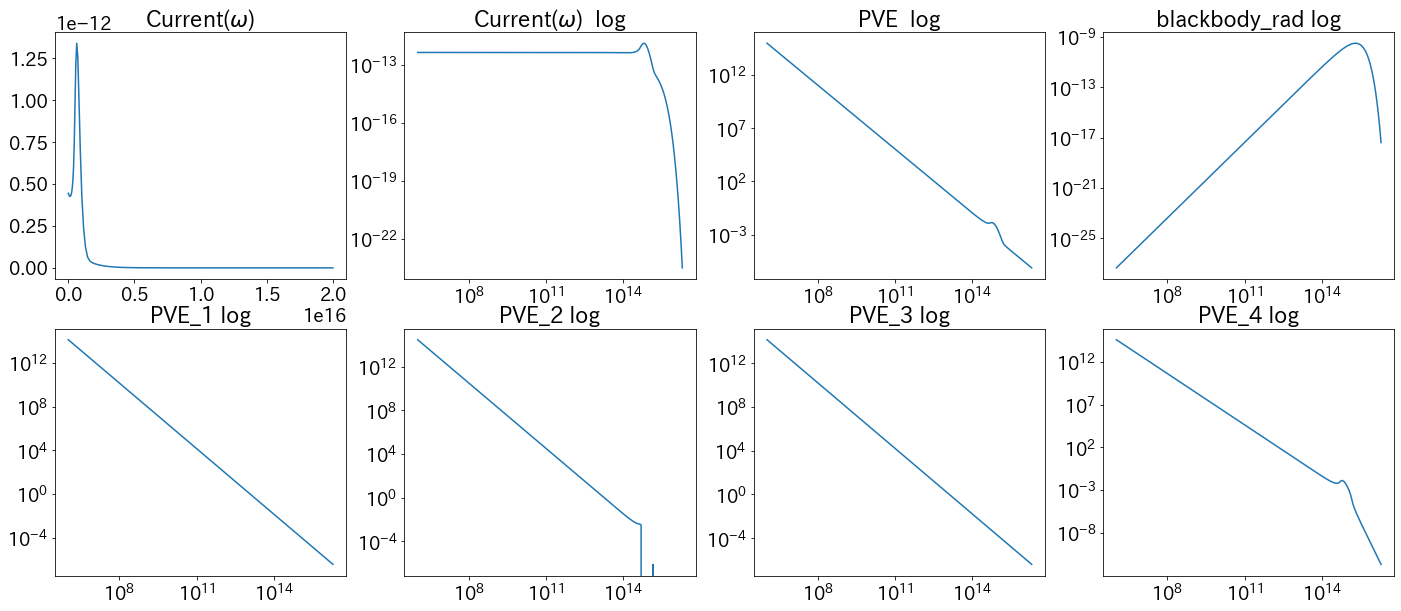

<ipython-input-22-0c15f966d3d6>:3: RuntimeWarning: invalid value encountered in log10
  tmp = np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1))
<ipython-input-22-0c15f966d3d6>:7: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(k, ws, np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1)), vmin=-15, vmax=-12, cmap='jet')
<ipython-input-22-0c15f966d3d6>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(k, ws, np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1)), vmin=-15, vmax=-12, cmap='jet')


max:-13.296833277163092, min:-25.53376367233191


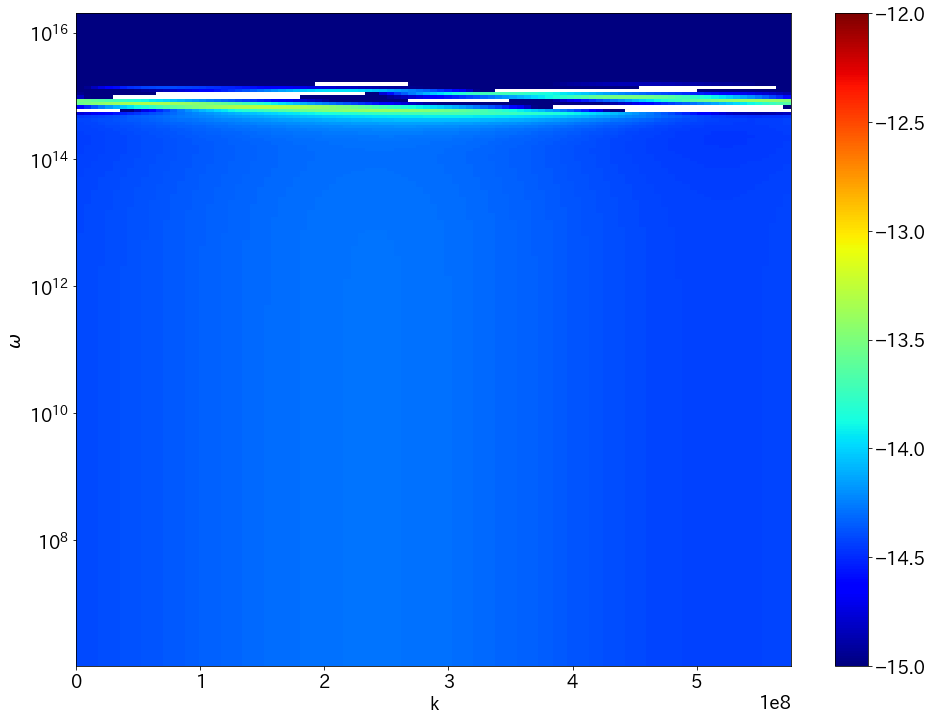

 25%|██▌       | 2/8 [40:04<2:00:04, 1200.80s/it]

if you want to load this: 
opt_state, logger = load_results('test_20220115_N12_k100_w200_T30000to300_tau1e-15_t1t2_lr0.03_600_fill12',4) 
params = get_params(opt_state)
300.0 1e-13 4 667.0881215911354


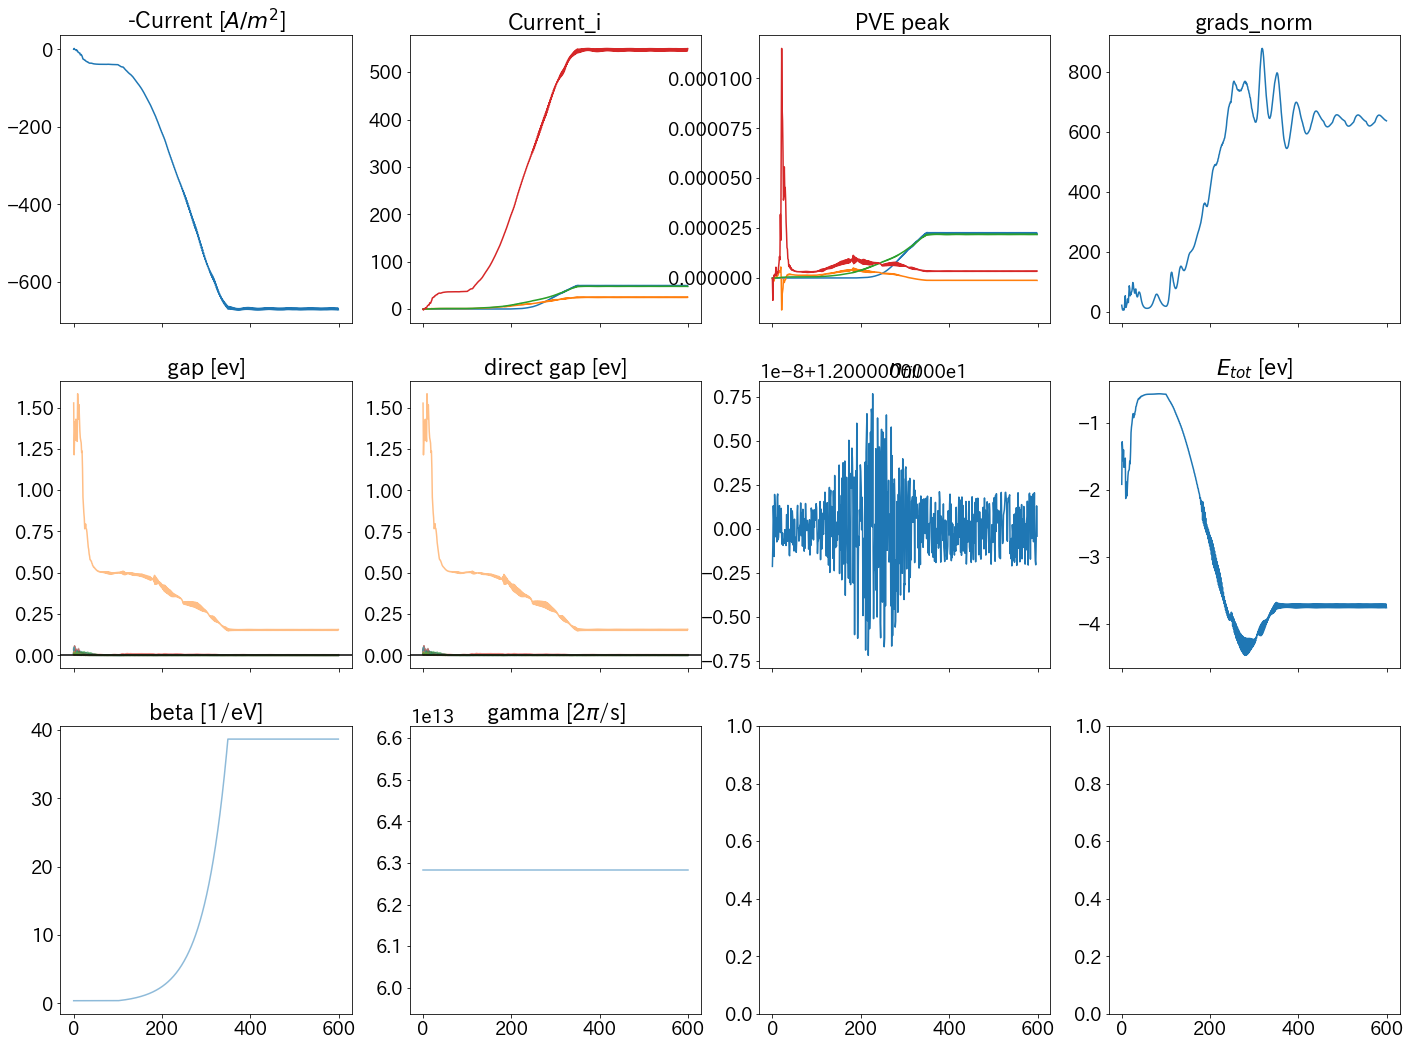

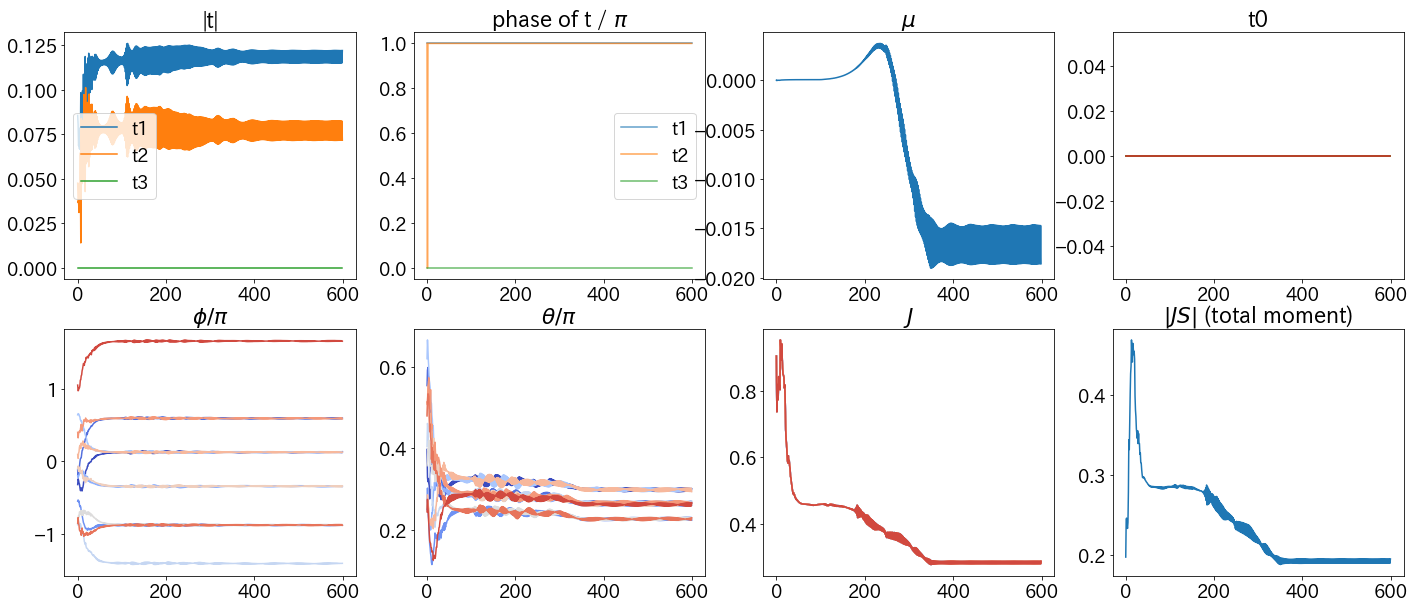

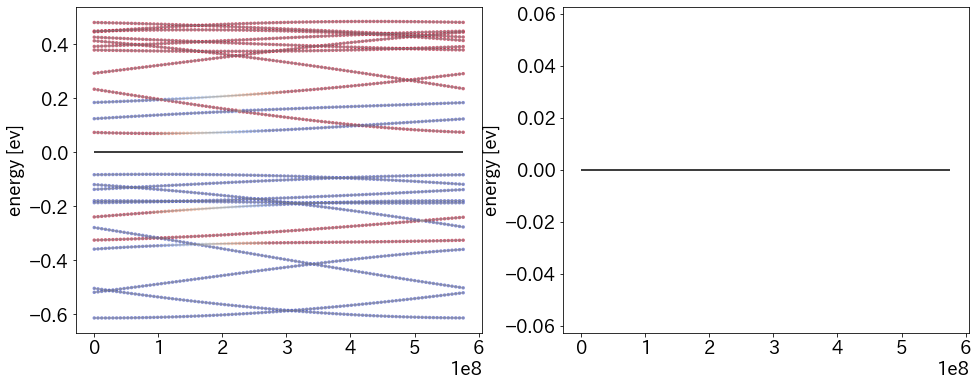

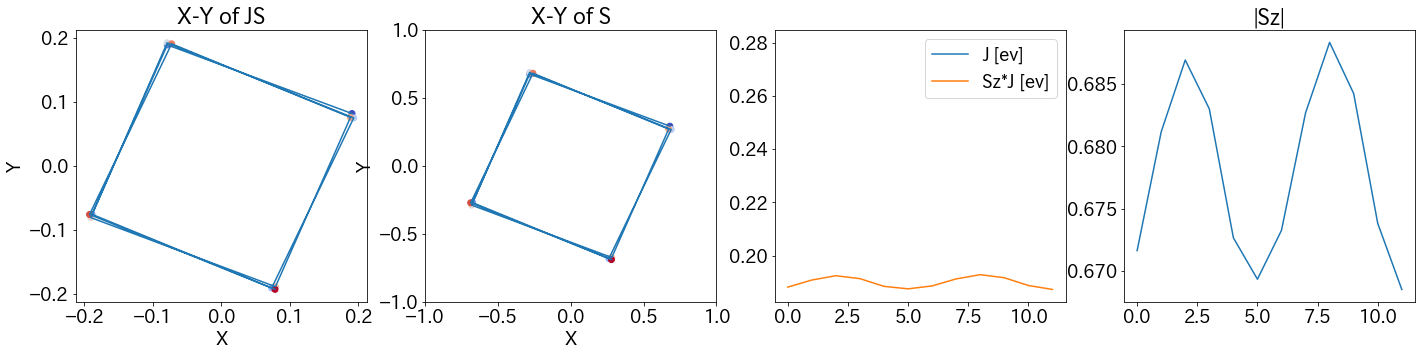

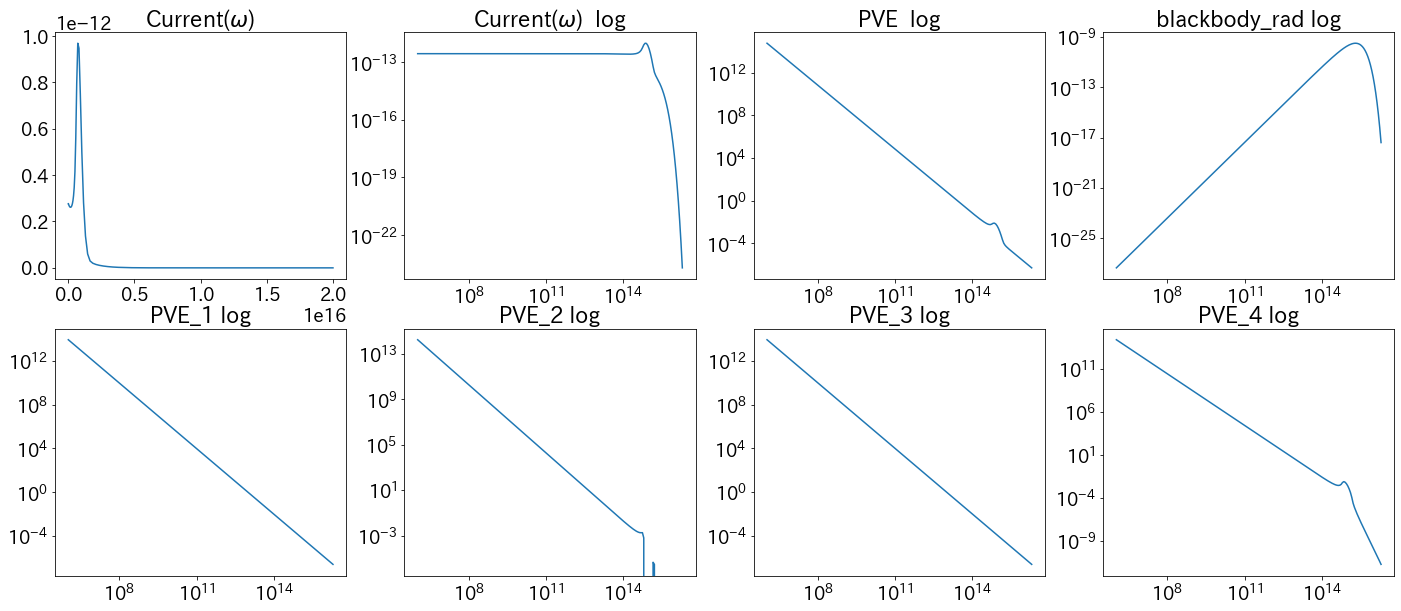

<ipython-input-22-0c15f966d3d6>:3: RuntimeWarning: invalid value encountered in log10
  tmp = np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1))
<ipython-input-22-0c15f966d3d6>:7: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(k, ws, np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1)), vmin=-15, vmax=-12, cmap='jet')
<ipython-input-22-0c15f966d3d6>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(k, ws, np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1)), vmin=-15, vmax=-12, cmap='jet')


max:-13.301632970585521, min:-25.714810294709704


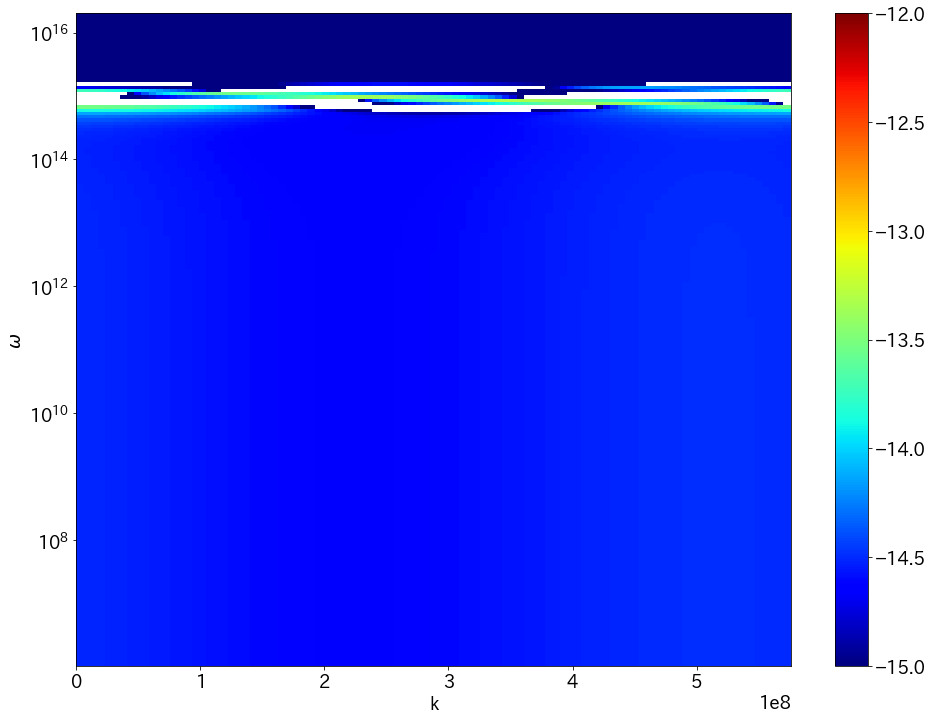

 38%|███▊      | 3/8 [59:52<1:39:33, 1194.72s/it]

if you want to load this: 
opt_state, logger = load_results('test_20220115_N12_k100_w200_T30000to300_tau1e-15_t1t2_lr0.03_600_fill12',5) 
params = get_params(opt_state)
300.0 1e-13 5 906.7209208998162


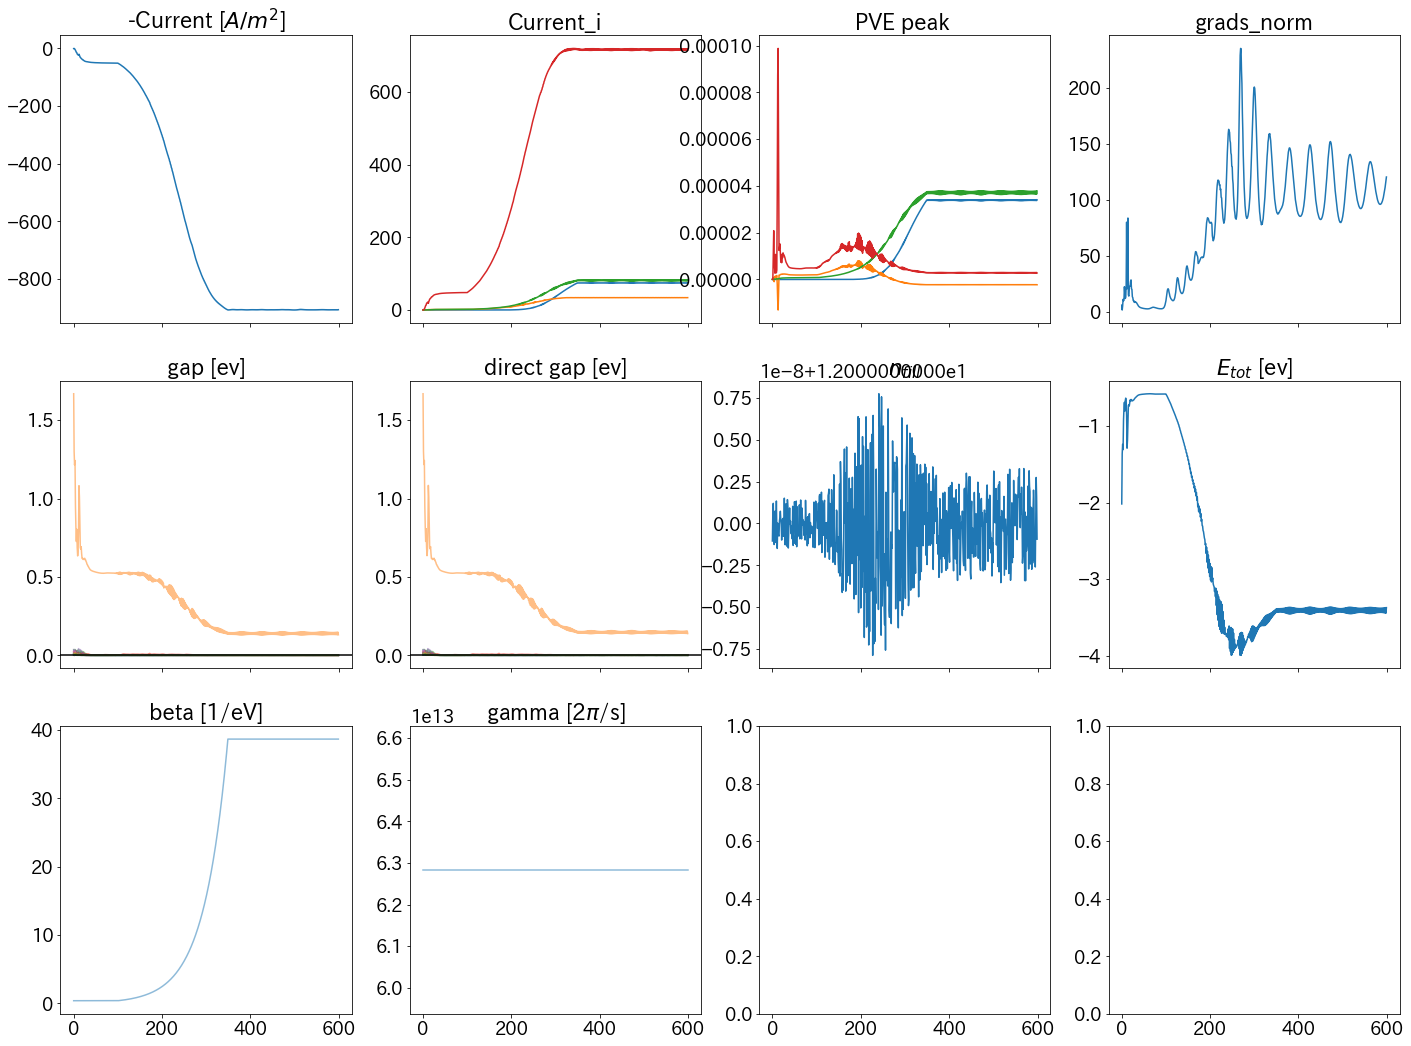

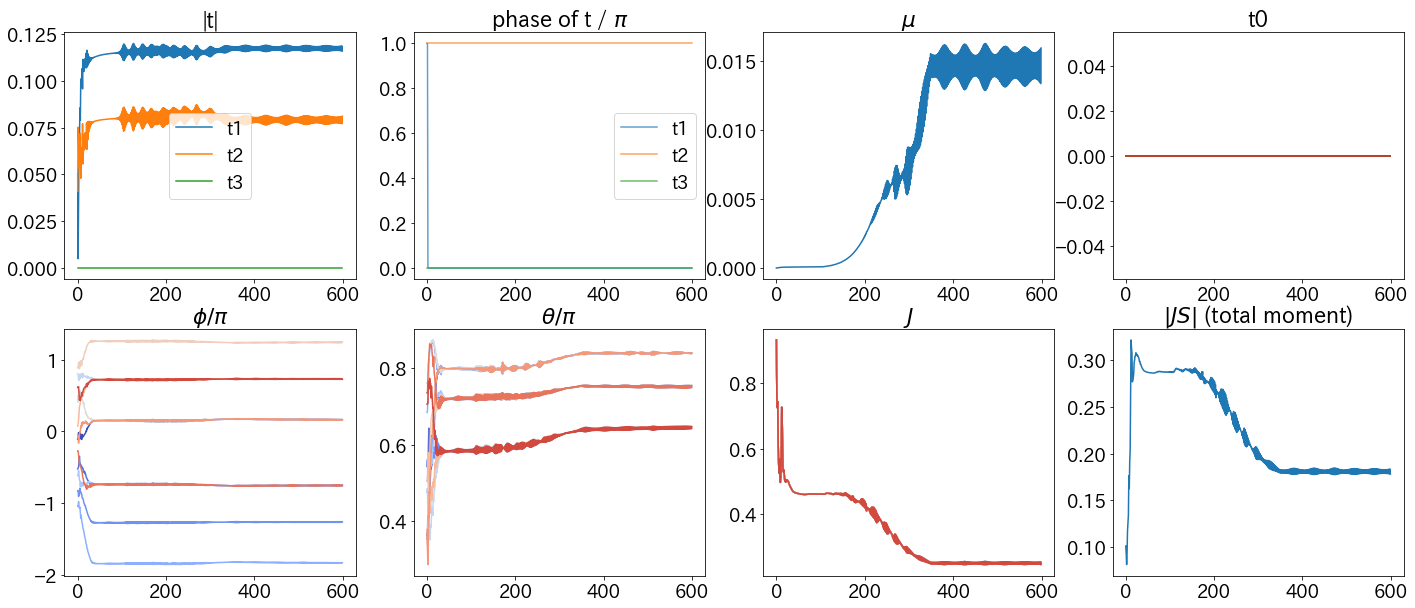

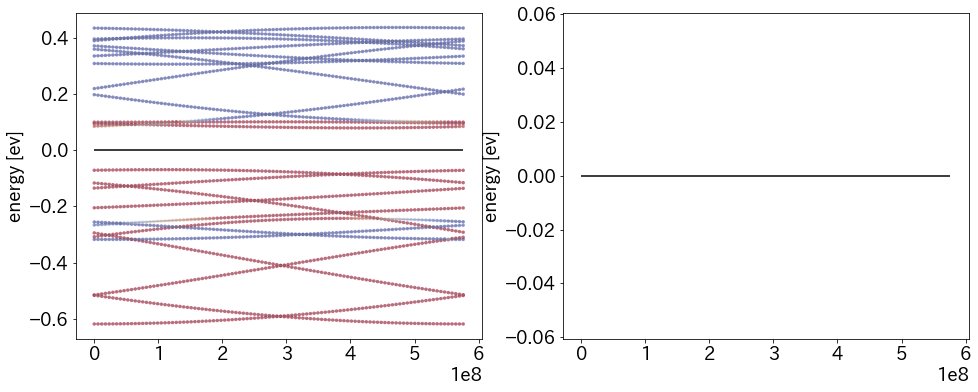

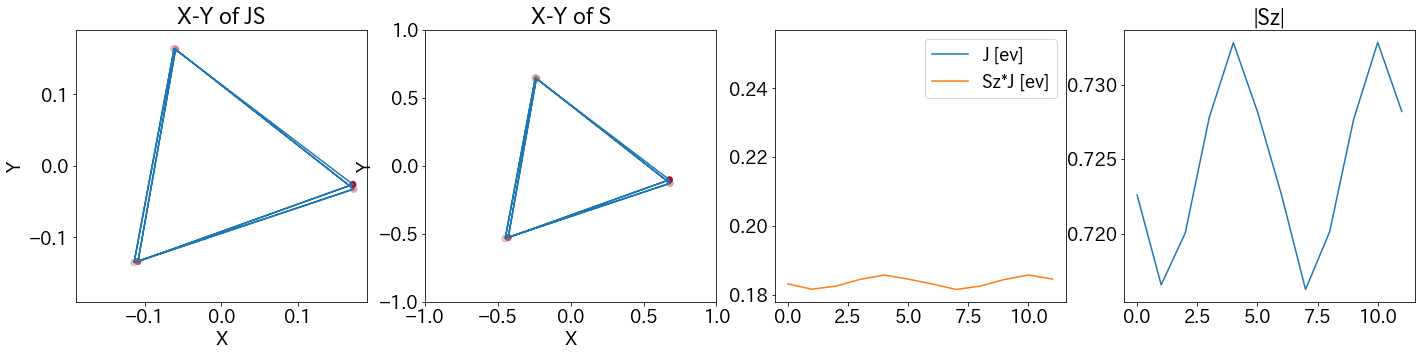

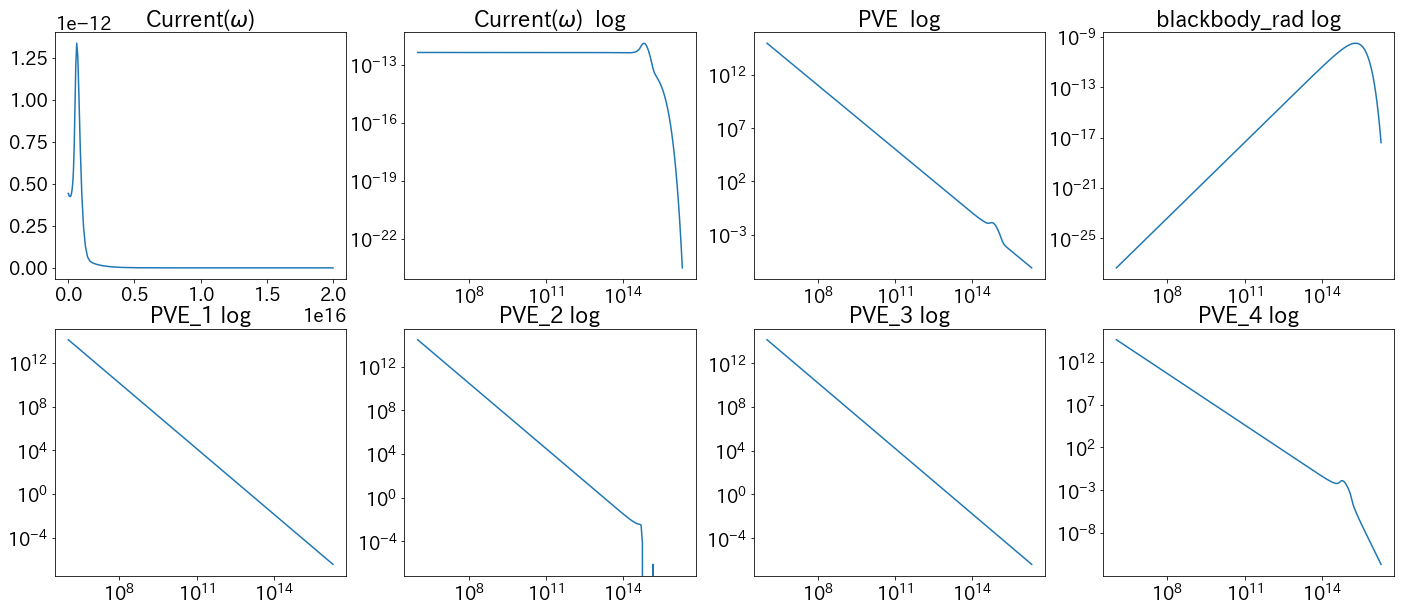

<ipython-input-22-0c15f966d3d6>:3: RuntimeWarning: invalid value encountered in log10
  tmp = np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1))
<ipython-input-22-0c15f966d3d6>:7: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(k, ws, np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1)), vmin=-15, vmax=-12, cmap='jet')
<ipython-input-22-0c15f966d3d6>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(k, ws, np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1)), vmin=-15, vmax=-12, cmap='jet')


max:-13.301918877114508, min:-25.534640652301608


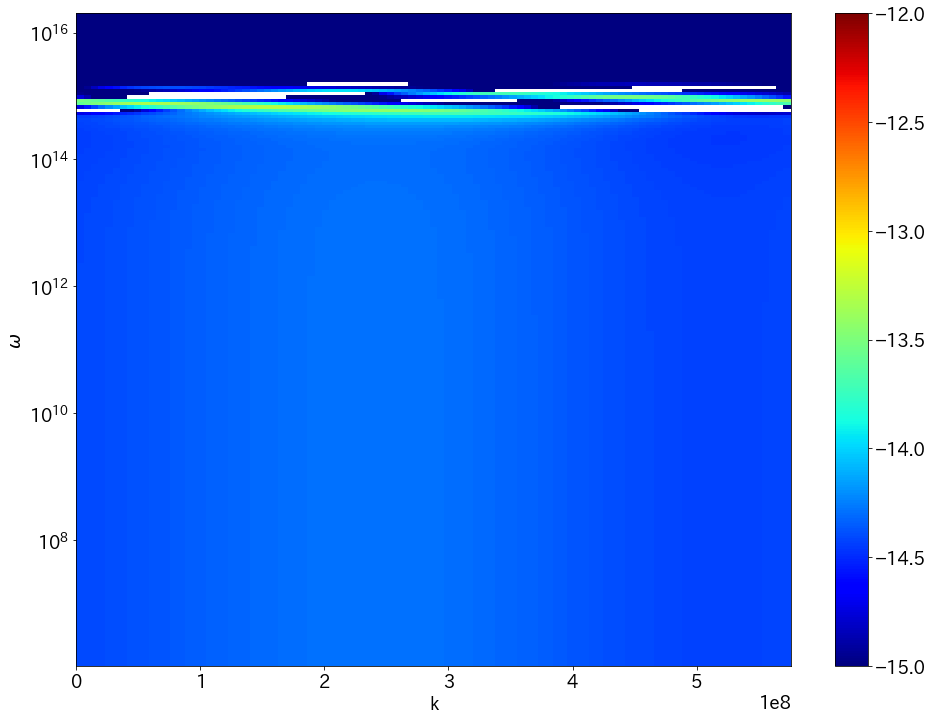

 50%|█████     | 4/8 [1:19:24<1:19:02, 1185.60s/it]

if you want to load this: 
opt_state, logger = load_results('test_20220115_N12_k100_w200_T30000to300_tau1e-15_t1t2_lr0.03_600_fill12',6) 
params = get_params(opt_state)
300.0 1e-13 6 380.55819852270787


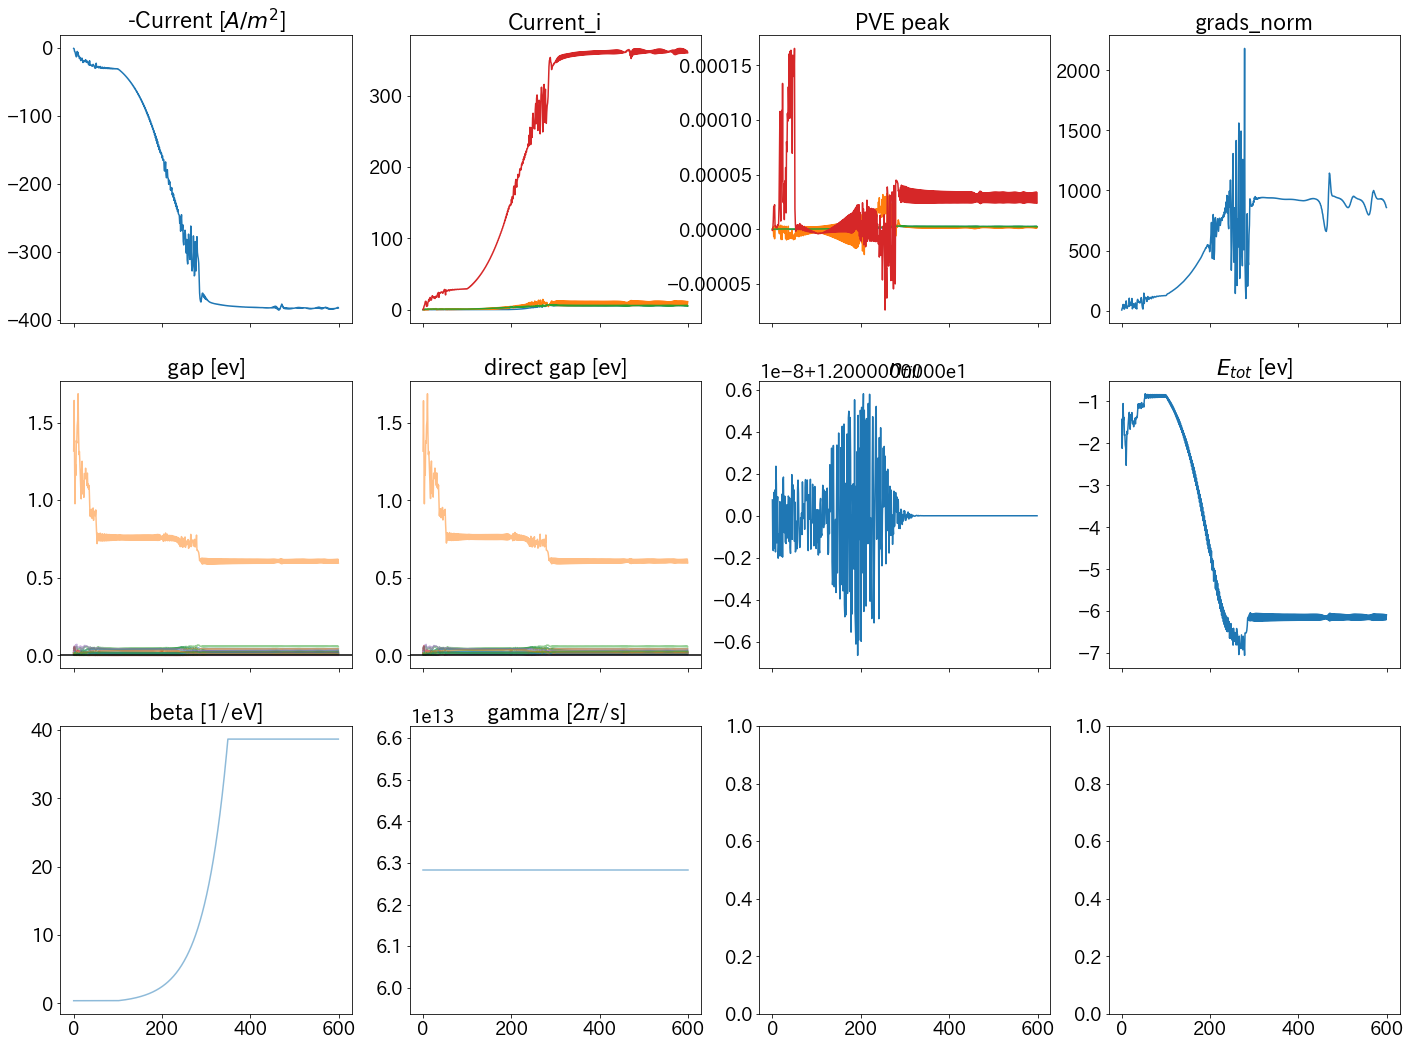

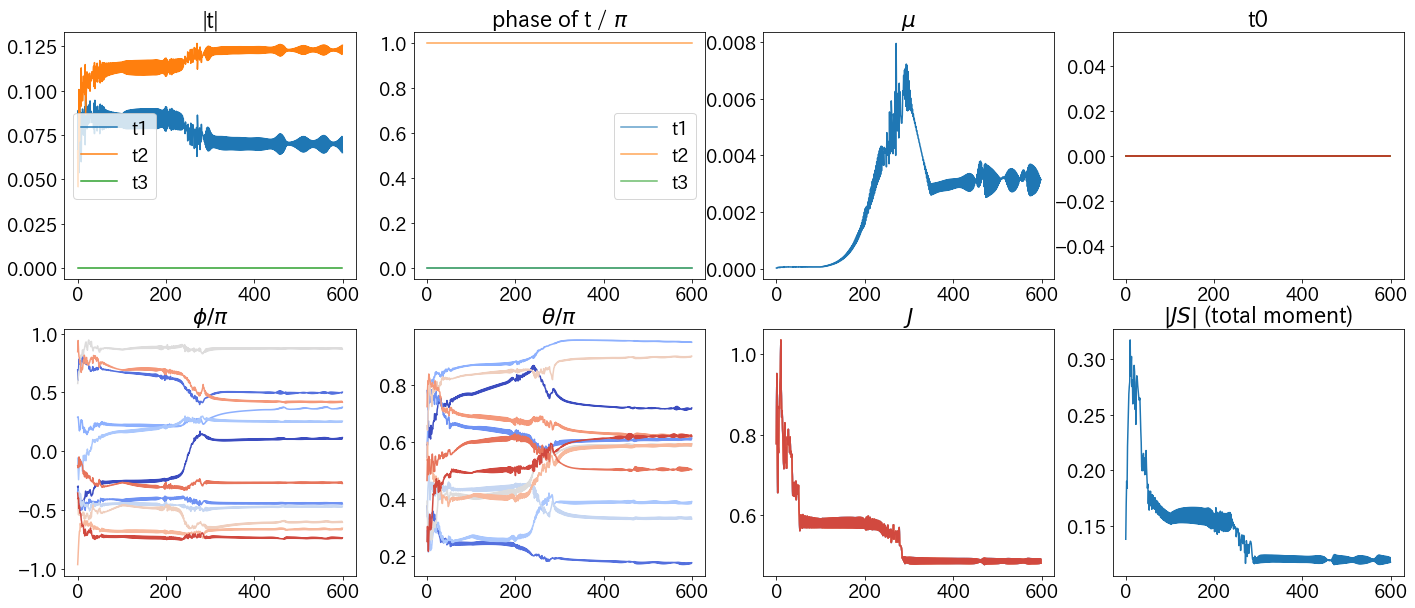

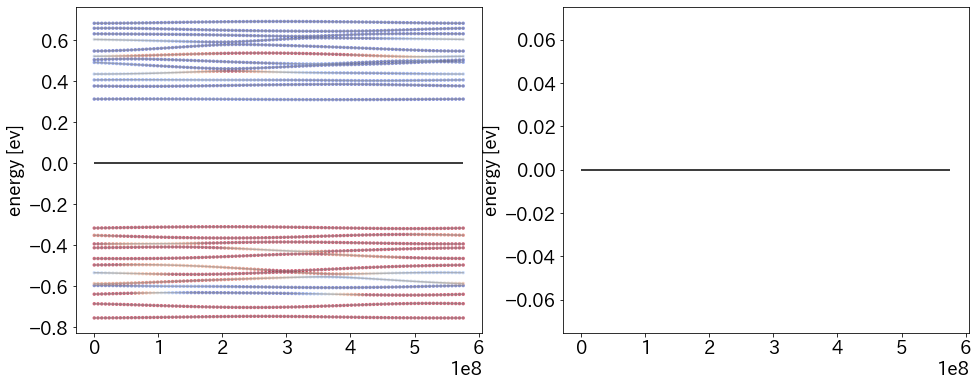

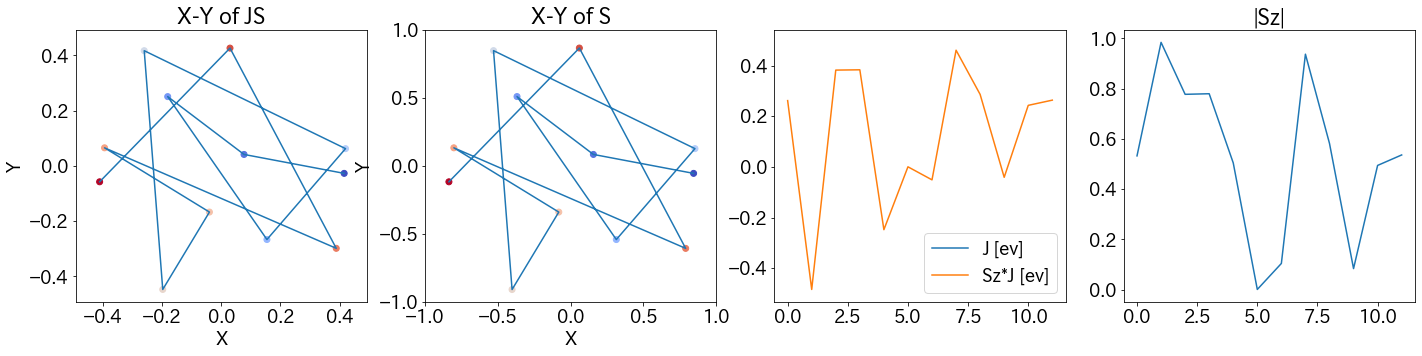

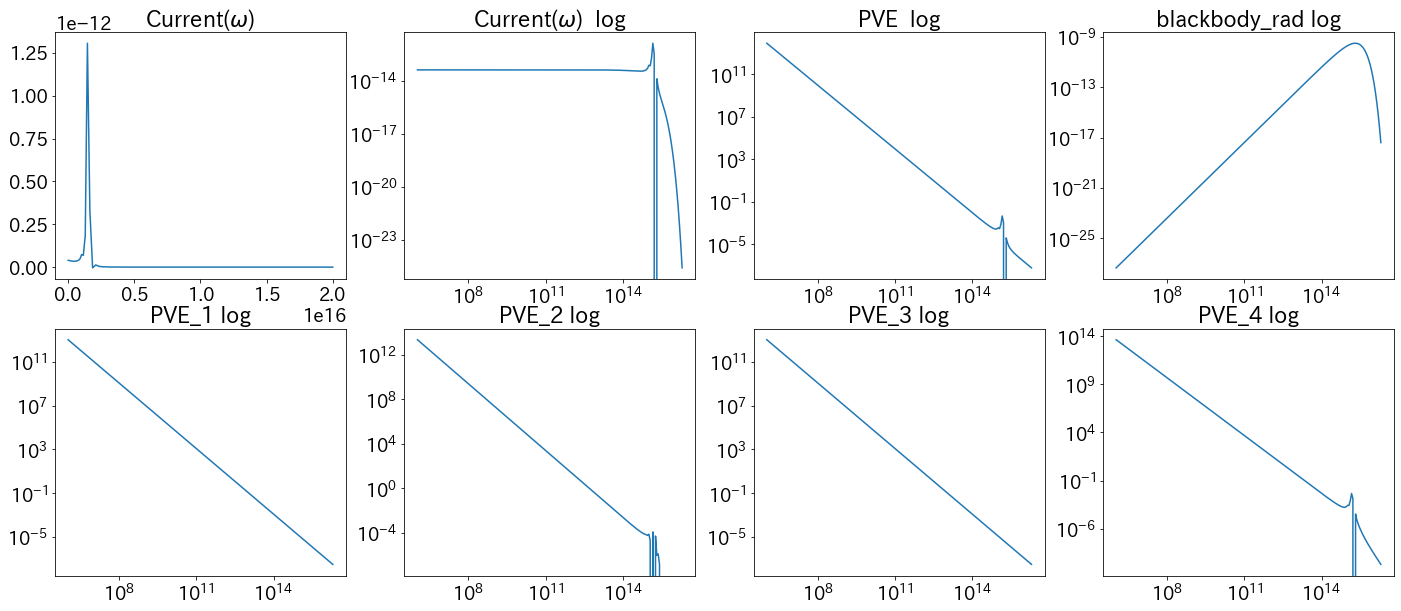

<ipython-input-22-0c15f966d3d6>:3: RuntimeWarning: invalid value encountered in log10
  tmp = np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1))
<ipython-input-22-0c15f966d3d6>:7: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(k, ws, np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1)), vmin=-15, vmax=-12, cmap='jet')
<ipython-input-22-0c15f966d3d6>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(k, ws, np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1)), vmin=-15, vmax=-12, cmap='jet')


max:-13.763334010720163, min:-26.645887095319953


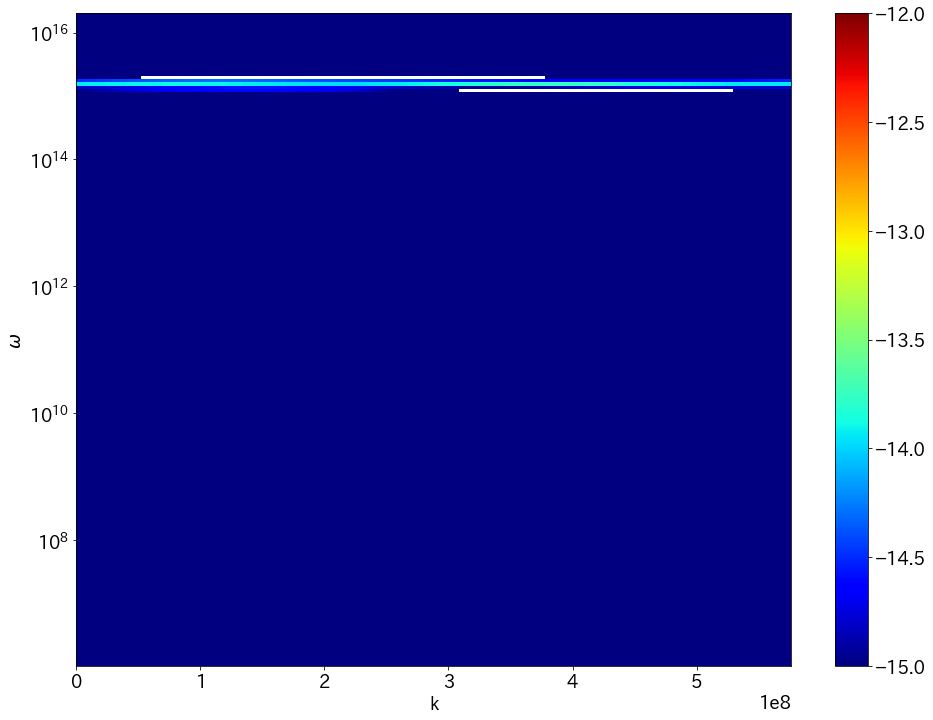

 62%|██████▎   | 5/8 [1:38:55<59:01, 1180.59s/it]  

if you want to load this: 
opt_state, logger = load_results('test_20220115_N12_k100_w200_T30000to300_tau1e-15_t1t2_lr0.03_600_fill12',7) 
params = get_params(opt_state)
300.0 1e-13 7 688.8509656490827


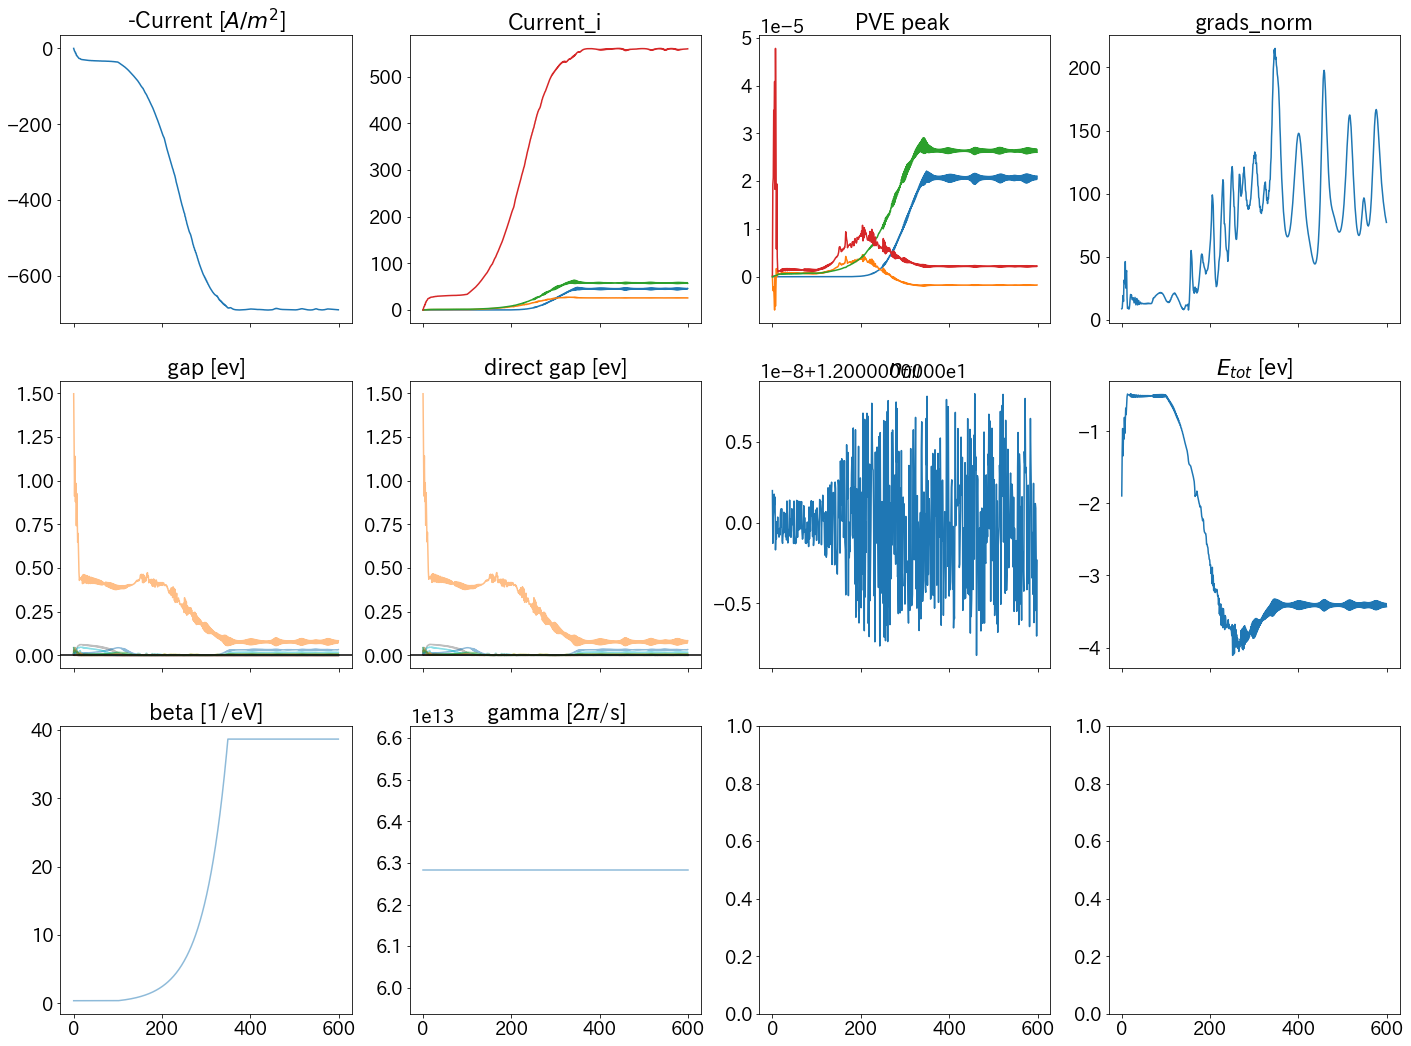

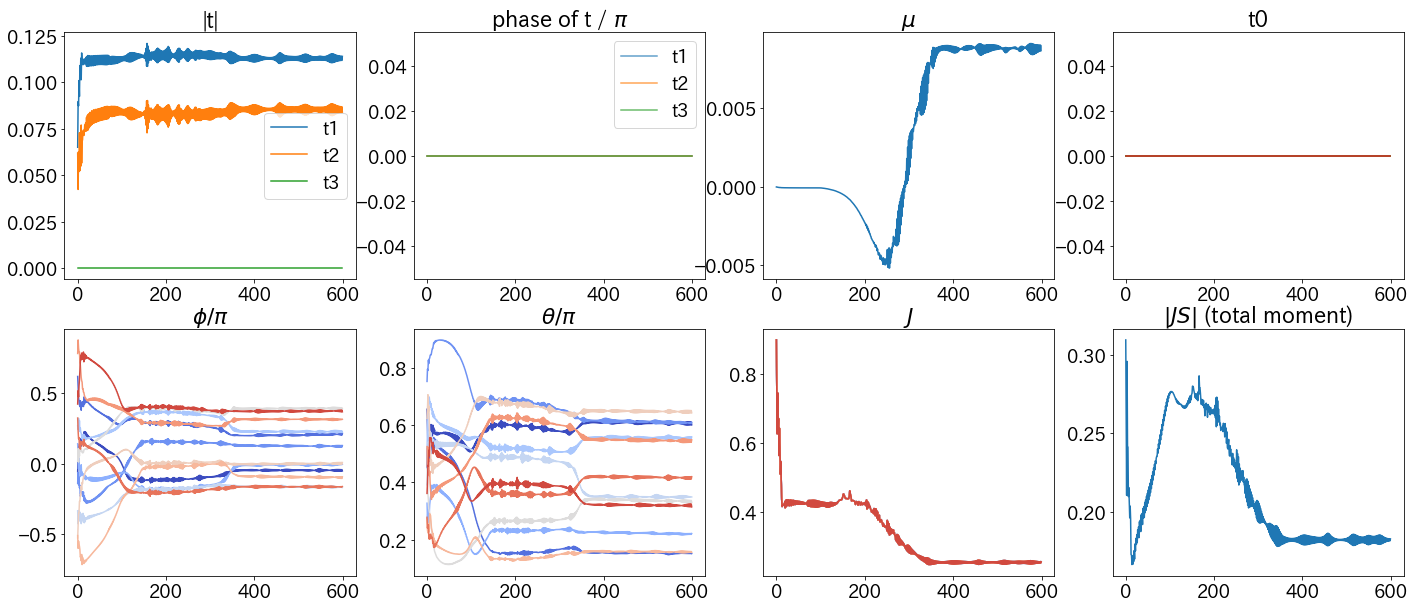

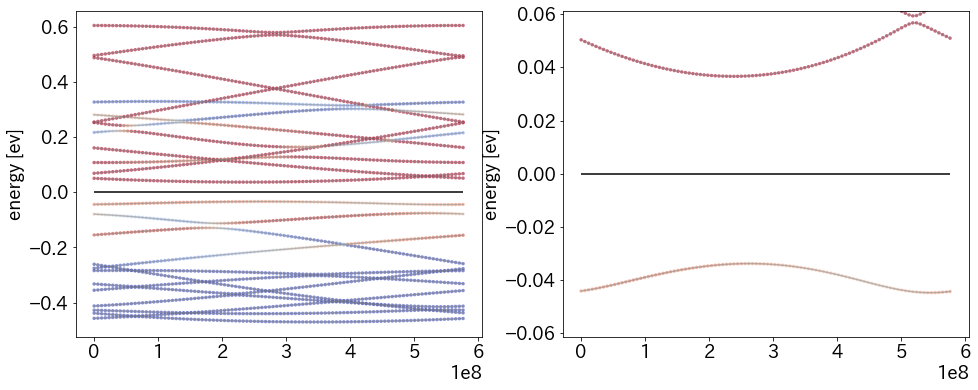

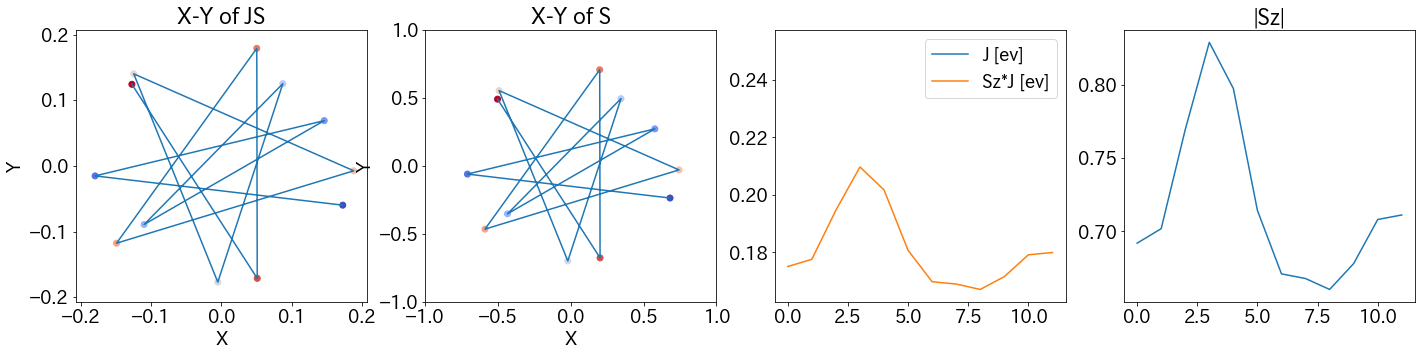

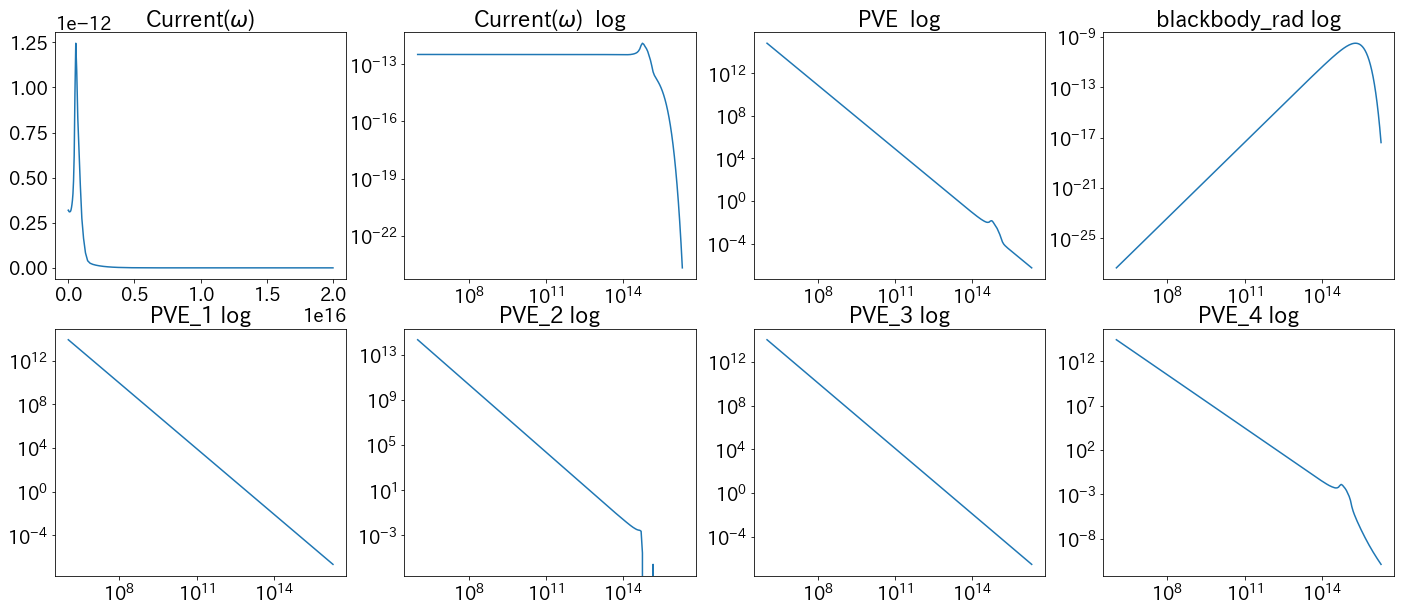

<ipython-input-22-0c15f966d3d6>:3: RuntimeWarning: invalid value encountered in log10
  tmp = np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1))
<ipython-input-22-0c15f966d3d6>:7: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(k, ws, np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1)), vmin=-15, vmax=-12, cmap='jet')
<ipython-input-22-0c15f966d3d6>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(k, ws, np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1)), vmin=-15, vmax=-12, cmap='jet')


max:-13.644848220489797, min:-25.69544163853885


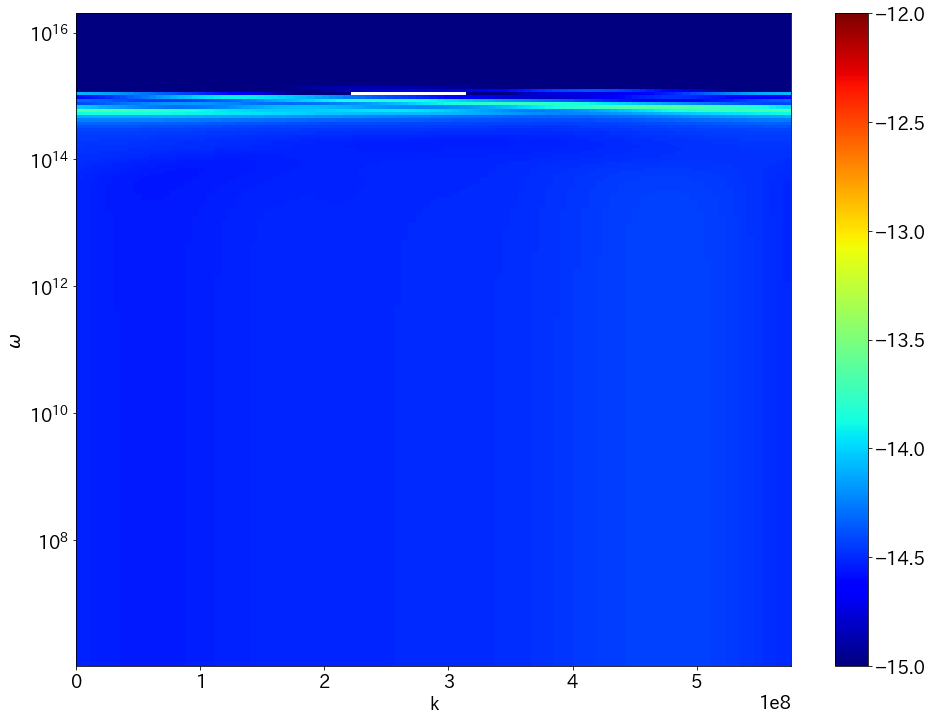

 75%|███████▌  | 6/8 [1:58:27<39:15, 1177.72s/it]

if you want to load this: 
opt_state, logger = load_results('test_20220115_N12_k100_w200_T30000to300_tau1e-15_t1t2_lr0.03_600_fill12',8) 
params = get_params(opt_state)
300.0 1e-13 8 671.007532814453


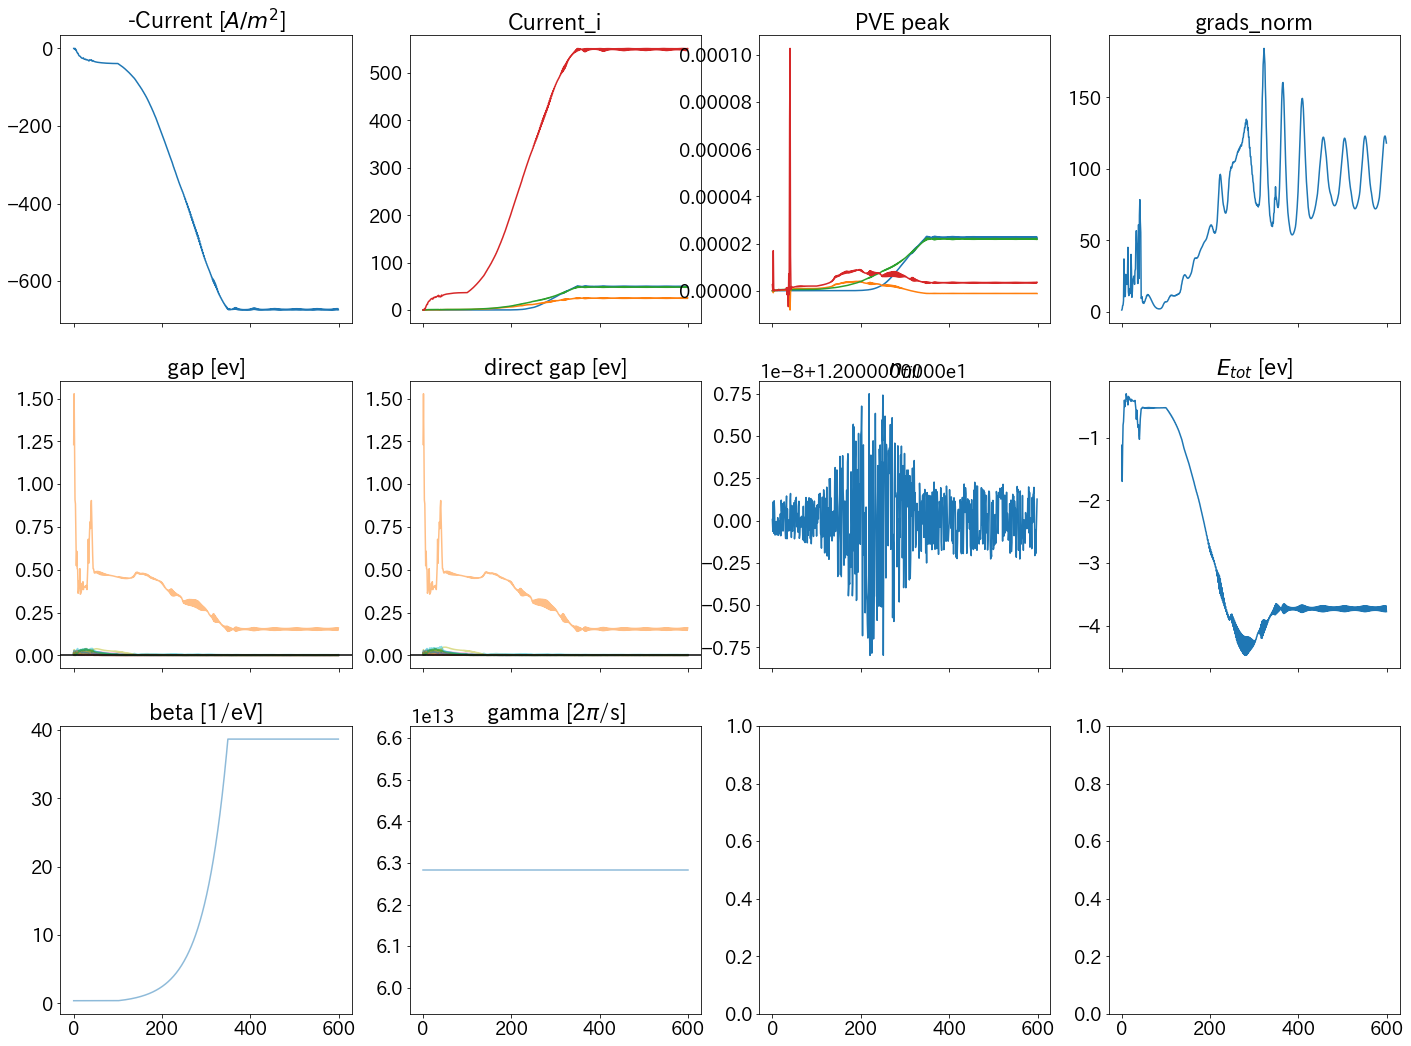

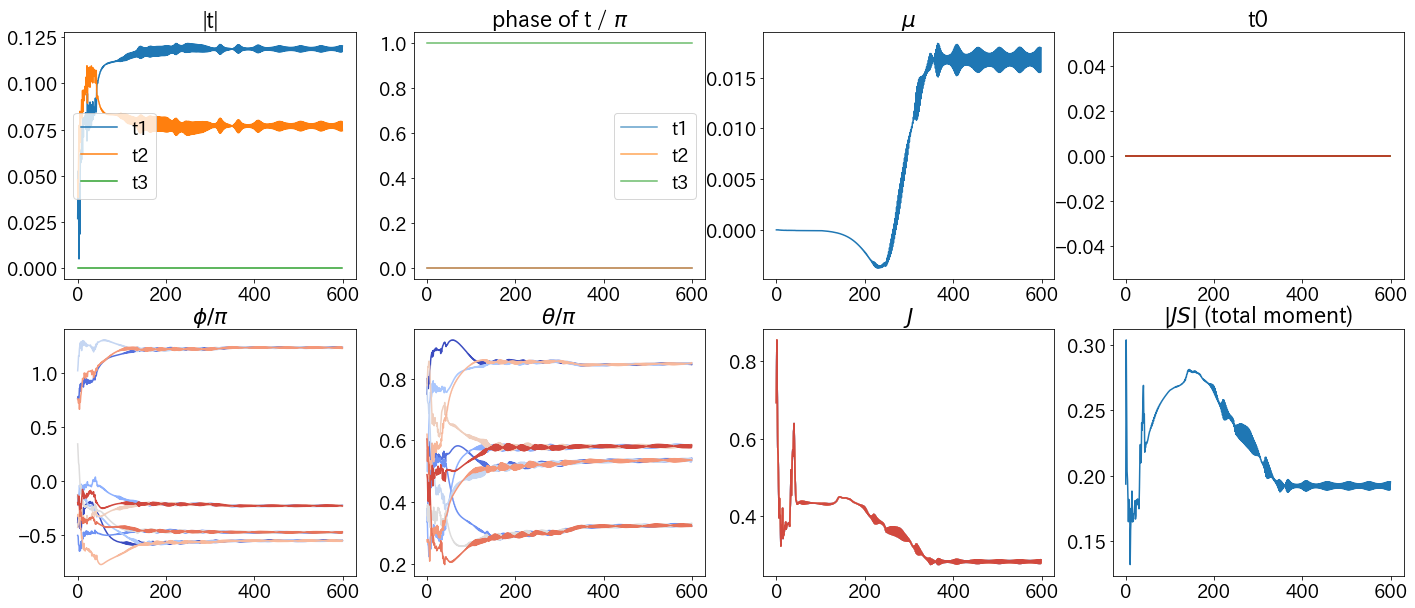

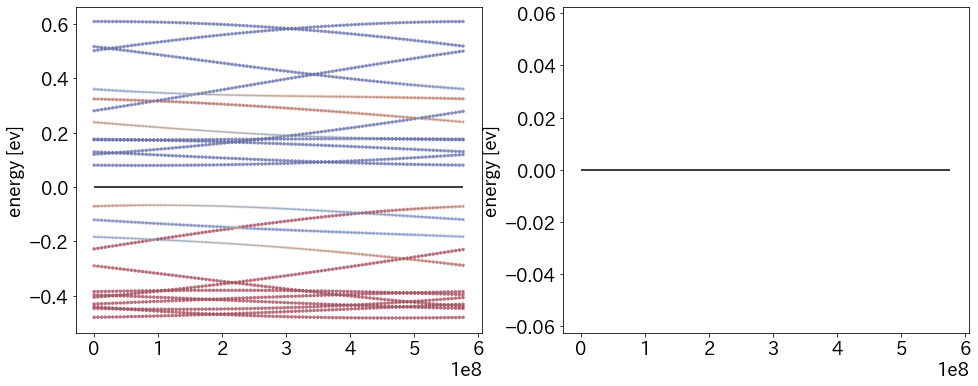

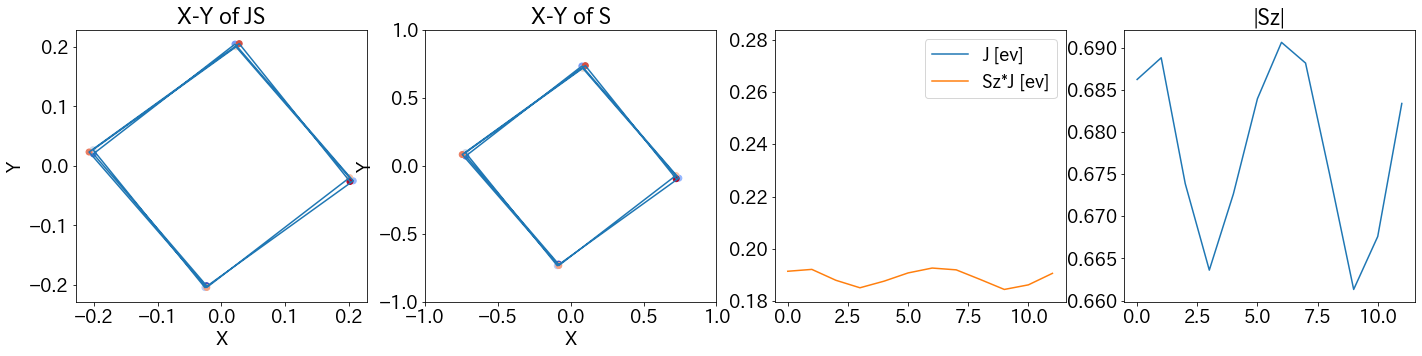

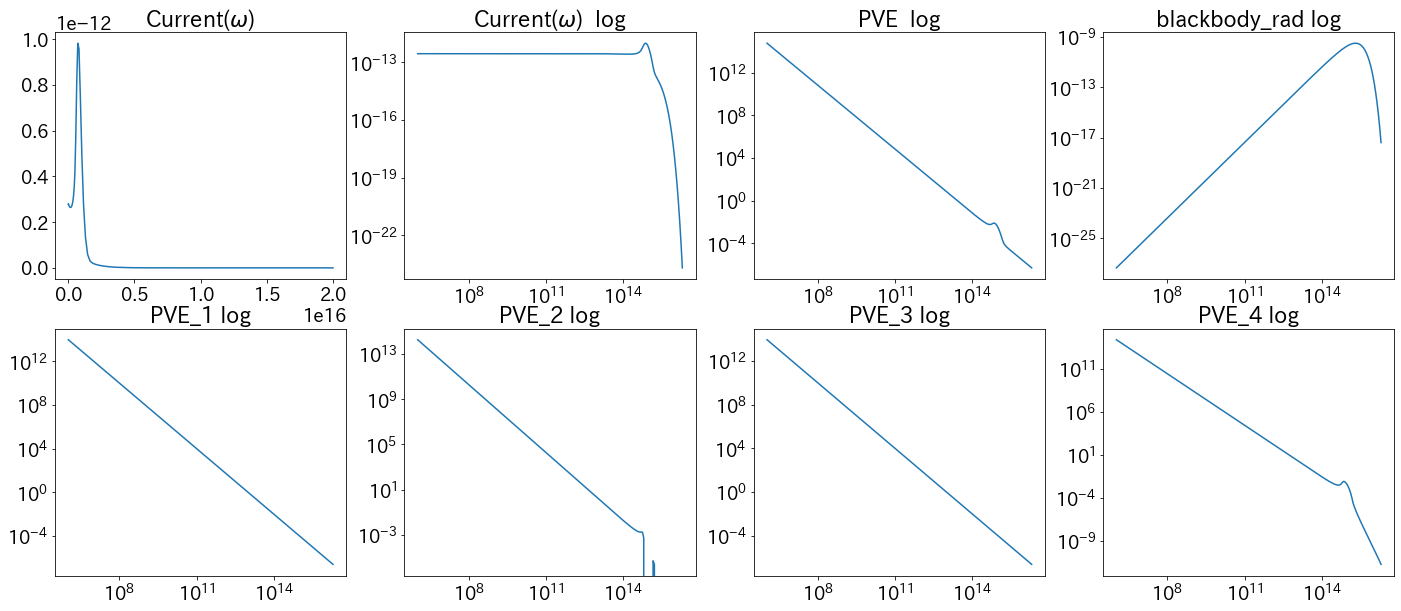

<ipython-input-22-0c15f966d3d6>:3: RuntimeWarning: invalid value encountered in log10
  tmp = np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1))
<ipython-input-22-0c15f966d3d6>:7: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(k, ws, np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1)), vmin=-15, vmax=-12, cmap='jet')
<ipython-input-22-0c15f966d3d6>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(k, ws, np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1)), vmin=-15, vmax=-12, cmap='jet')


max:-13.331376900521803, min:-25.710180889874717


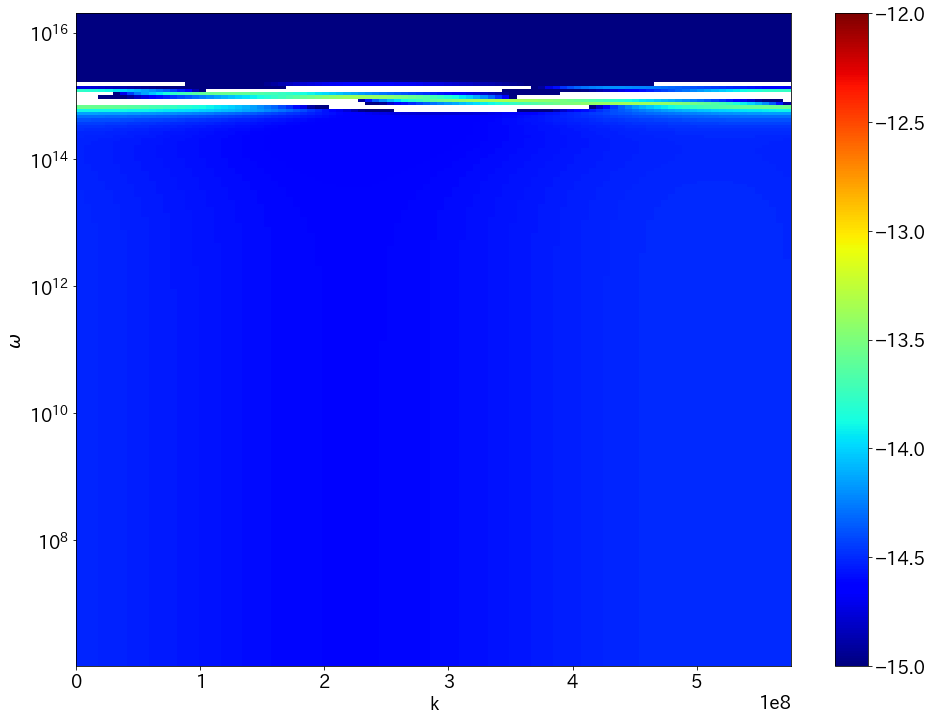

 88%|████████▊ | 7/8 [2:18:04<19:37, 1177.25s/it]

if you want to load this: 
opt_state, logger = load_results('test_20220115_N12_k100_w200_T30000to300_tau1e-15_t1t2_lr0.03_600_fill12',9) 
params = get_params(opt_state)
300.0 1e-13 9 900.65295945373


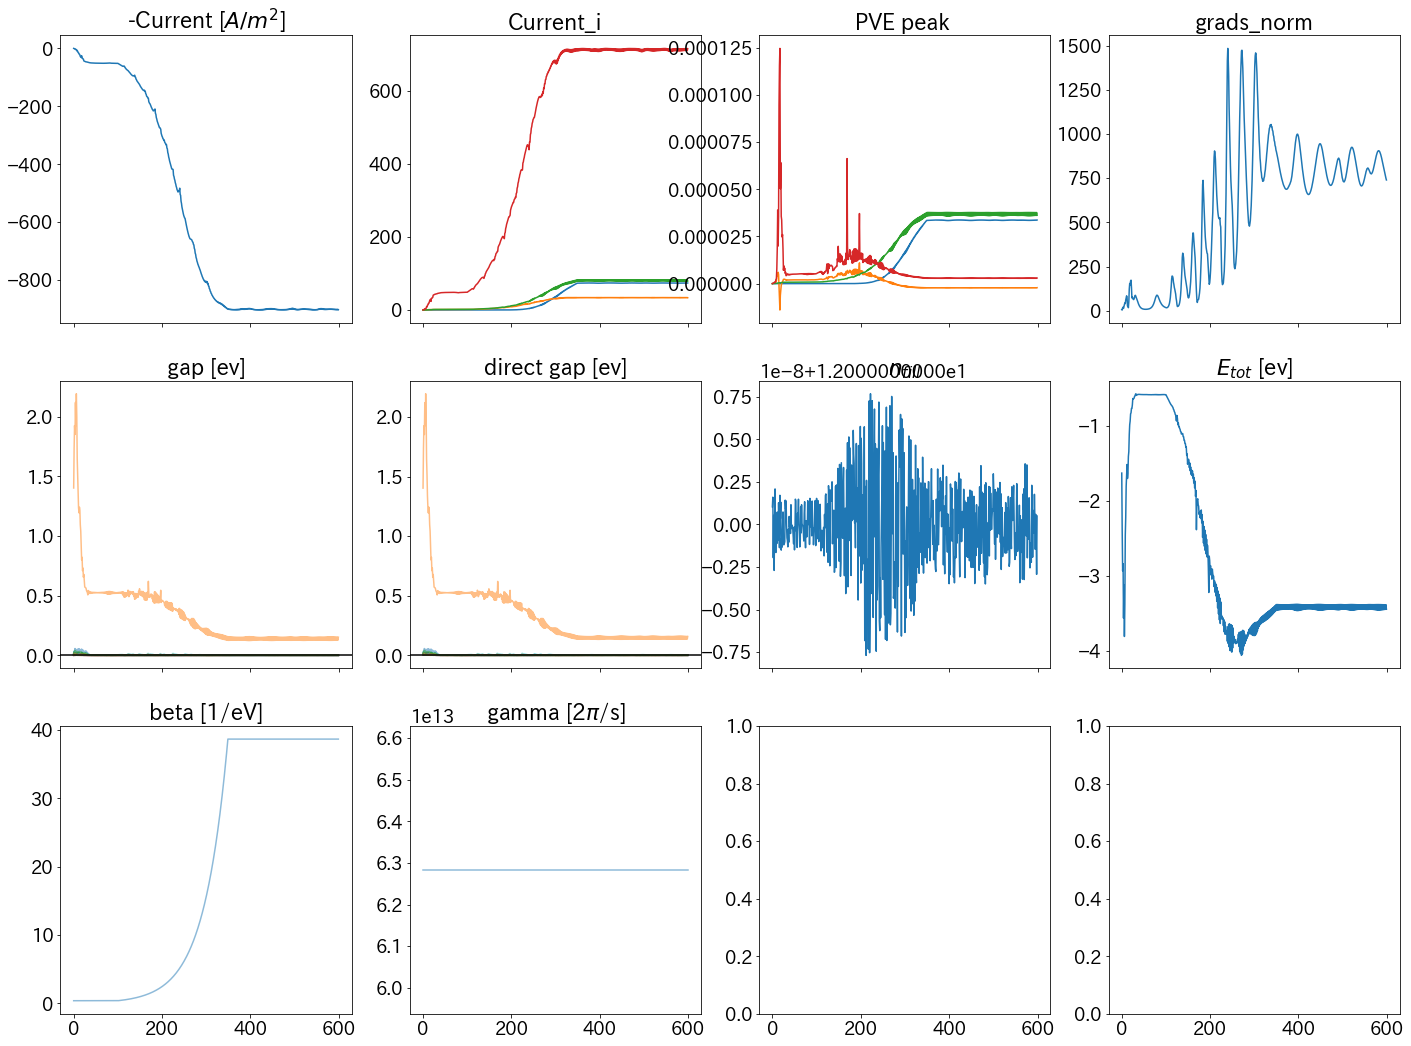

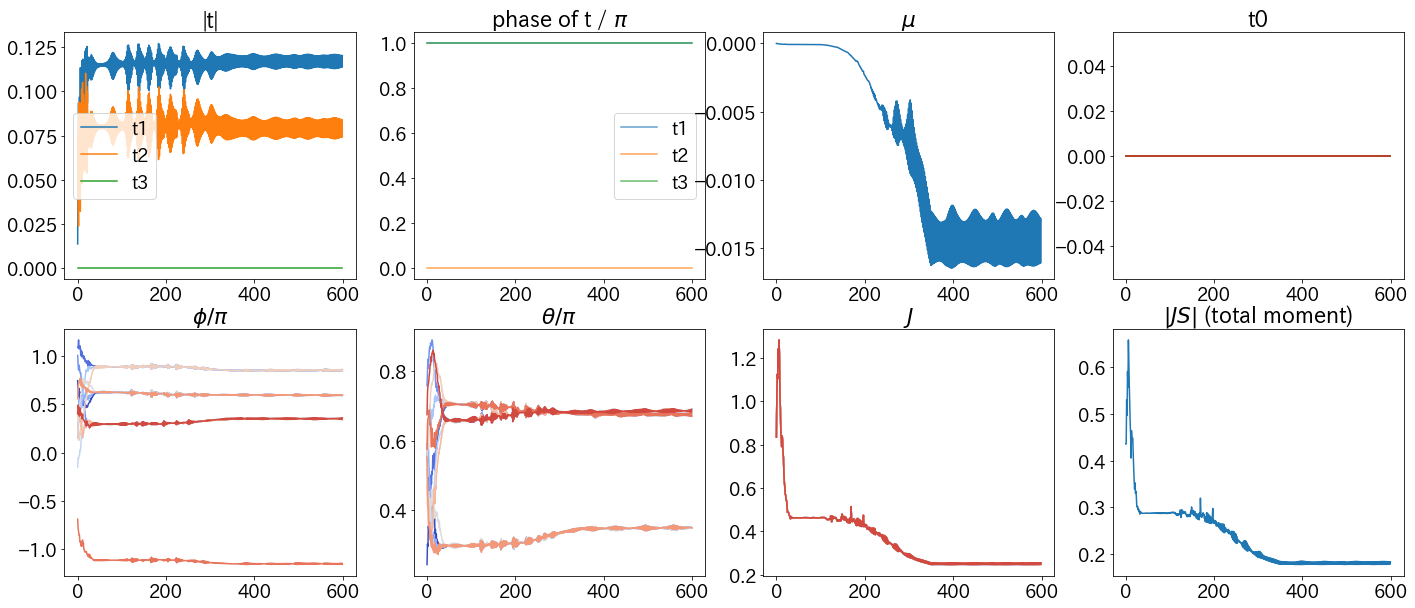

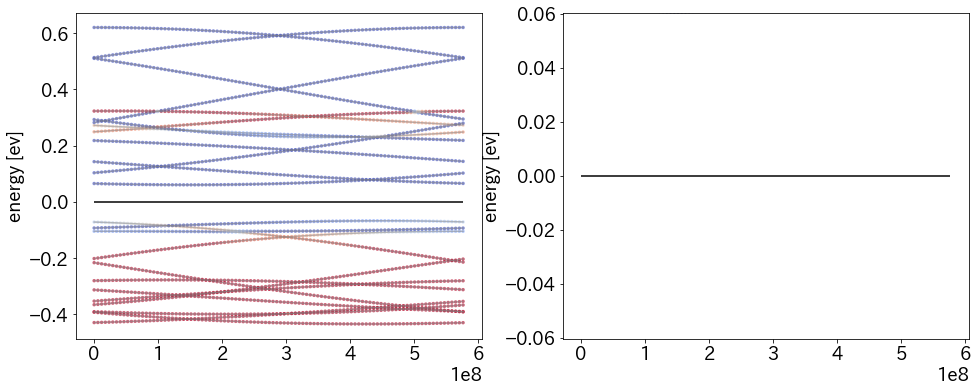

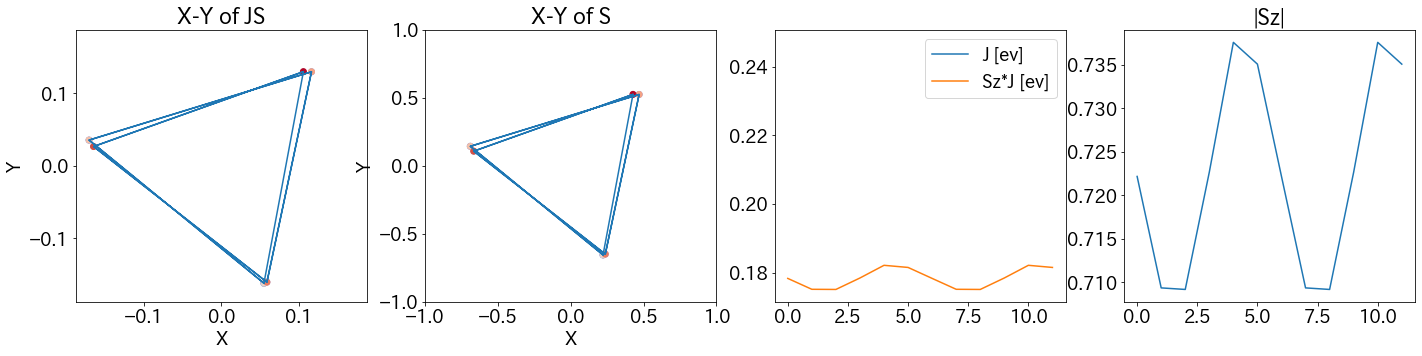

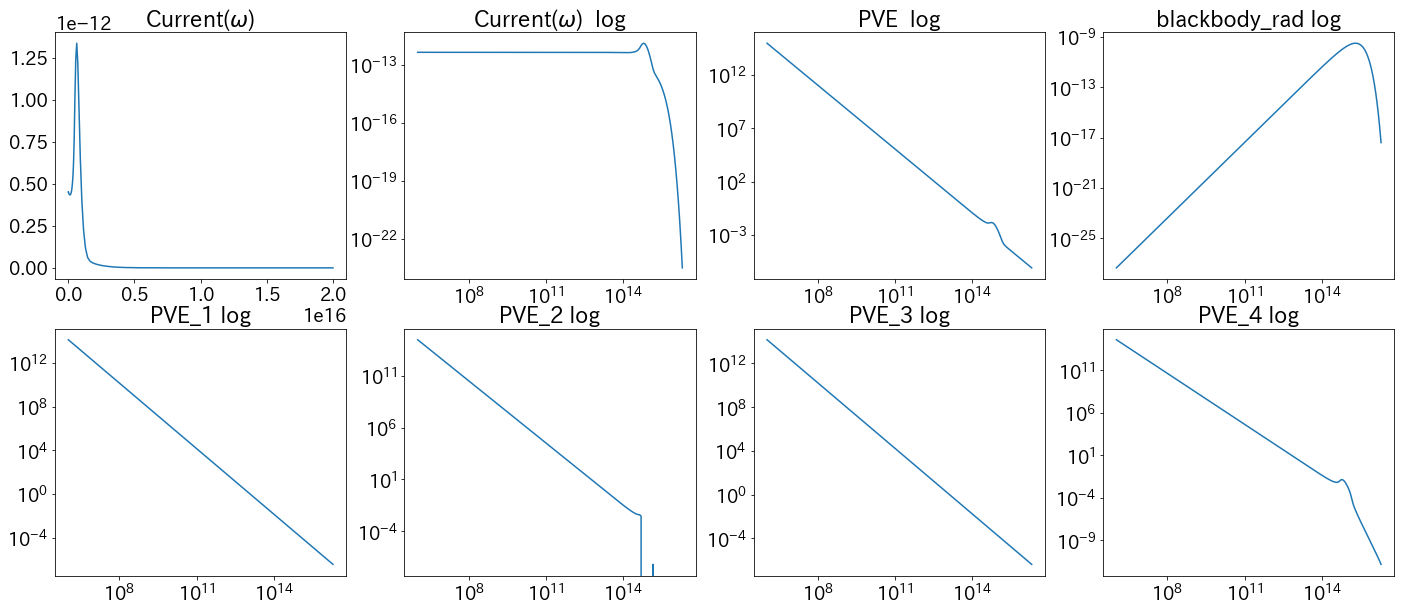

<ipython-input-22-0c15f966d3d6>:3: RuntimeWarning: invalid value encountered in log10
  tmp = np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1))
<ipython-input-22-0c15f966d3d6>:7: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(k, ws, np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1)), vmin=-15, vmax=-12, cmap='jet')
<ipython-input-22-0c15f966d3d6>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(k, ws, np.log10(PVE.real*blackbody_rad_modified.reshape(-1,1)), vmin=-15, vmax=-12, cmap='jet')


max:-13.249077884563864, min:-25.53593393500472


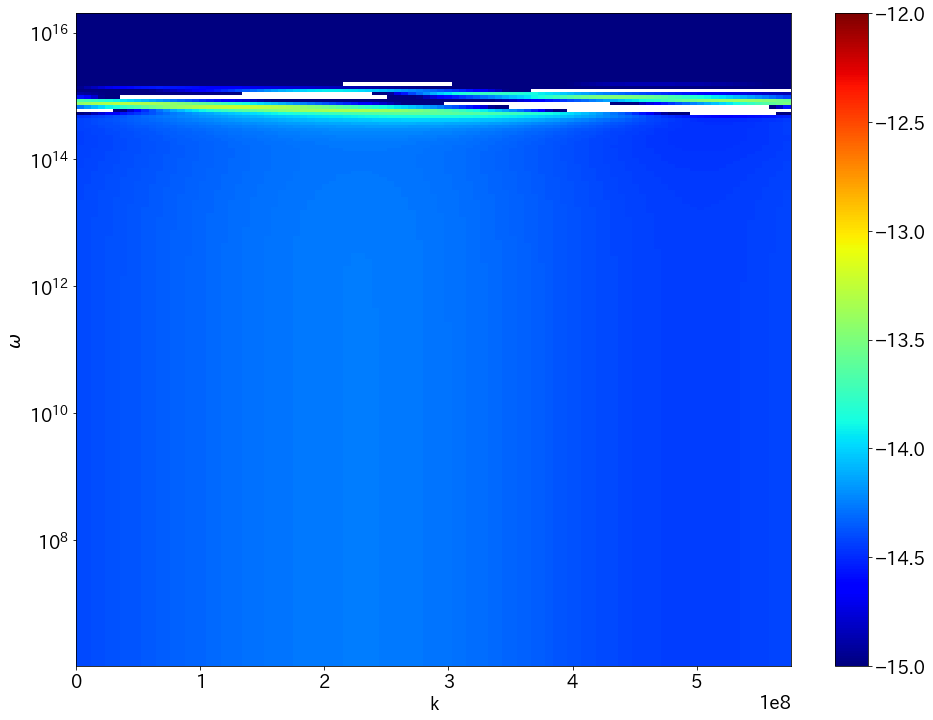

100%|██████████| 8/8 [2:37:35<00:00, 1182.00s/it]

CPU times: user 8h 42min 37s, sys: 2min 36s, total: 8h 45min 13s
Wall time: 2h 37min 35s


In [42]:
%%time
for seed in tqdm(range(2,10)):
    num_steps=600

    _,_, get_params = optimizers.rmsprop(0.1, gamma=0.99)
    params_init = get_initial(seed)

    logger = {}
    text_condition = f'pve'

    step_init = 0 if logger == {} else len(logger['logbeta'])
    xs = {'step': step_init + jnp.arange(num_steps)}
    temperatures = jnp.concatenate([jnp.array([30000]*100), jnp.geomspace(30000, 300, num_steps-350), jnp.array([300]*250)])
    taus = jnp.array([1e-13]*num_steps)
    xs['beta'] = jnp.array(1.0/temperatures)/k_b # 室温
    xs['gamma'] = 2*jnp.pi/(taus)

    dic_opt = {'step_loops': [], 'step_sizes': [0.03]}

    opt_state, logger_tmp = train(xs, params_init, k, ws, filling, blackbody_rad_modified, dic_opt, hc_cond)
    logger = cat_logger(logger, logger_tmp)
    params = get_params(opt_state)
    save_results(opt_state, logger, text_condition, seed)

    beta, temperature, tau, gamma = xs['beta'][-1], temperatures[-1], taus[-1], xs['gamma'][-1]
    hc, e, v, mu, ws, PVE_1, PVE_2, PVE_3, PVE_4, Current, S_modified = calc_results(params, k, ws, beta, filling, gamma, blackbody_rad_modified, hc_cond)

    print(temperature, tau, seed, Current)
    plot_logger(logger, blackbody_rad_modified)
    plot_JS(logger)
    #plot_band(k, e, v, mu)
    #plot_spin_potential(hc)
    plot_JS_last(hc, S_modified)
    #plot_PVE(PVE_1, PVE_2, PVE_3, PVE_4, blackbody_rad_modified)
    #plot_profile(params, beta, gamma, filling, hc_cond)

# Figure

## main

In [64]:
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'grid.linestyle': '-'})
sns.set_context("paper", 2.0, {"lines.linewidth": 3, 'font.size': 9}) # これでフォントが9*2=18になっているはず？ : https://stackoverflow.com/questions/36220829/fine-control-over-the-font-size-in-seaborn-plots-for-academic-papers/36222162

from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.transforms import Bbox
from matplotlib.colors import LinearSegmentedColormap

In [65]:
def my_color(ii):
    """
    hexade
    base: RGB:79,84,208
    """
    c_h, c_s, c_v = colorsys.rgb_to_hsv(79.0/255, 84.0/255, 208.0/255)
    return colorsys.hsv_to_rgb((c_h+ii*1.0/8)%1.0, c_s, c_v)

c_h, c_s, c_v = colorsys.rgb_to_hsv(79.0/255, 84.0/255, 208.0/255)

In [60]:
def calc_PVE_k_band(e_k, v_k, A_k, B_k, C_k, w, beta, gamma, mu):
    """
    Calculate the value of Photoboltaic Effect at each k point using second-order respose theory. 
    see Eq. (5) and (9-12) in https://doi.org/10.1103/PhysRevB.104.L180407 (or https://arxiv.org/abs/2108.00674) for detail. 
    """
    
    fm_k = fm(e_k, beta, mu)
    fm_diff_k = fm_k.reshape(2*N, 1) - fm_k.reshape(1, 2*N)
    e_diff_k = (e_k.reshape(2*N, 1) - e_k.reshape(1, 2*N))/hbar
    
    PVE_1_k_band = -ec**3*(fm_k*jnp.diagonal(C_k))/(hbar*w)**2
    PVE_2_k_band = -ec**3*(fm_diff_k*A_k*B_k.T/(w+1j*gamma-e_diff_k) + fm_diff_k*A_k*B_k.T/(-w+1j*gamma-e_diff_k)).sum(axis=0)/(hbar*w)**2
    PVE_3_k_band = -ec**3*(fm_diff_k*B_k*A_k.T/(1j*gamma - e_diff_k)).sum(axis=0)/(hbar*w)**2
    
    A_k_ab = A_k.reshape(2*N, 2*N, 1)
    A_k_bc = A_k.reshape(1, 2*N, 2*N)
    A_k_ca = A_k.T.reshape(2*N, 1, 2*N)

    fm_diff_k_ab = fm_diff_k.reshape(2*N, 2*N, 1)
    fm_diff_k_cb = fm_diff_k.T.reshape(1, 2*N, 2*N)

    e_diff_k_ba = e_diff_k.T.reshape(2*N, 2*N, 1)
    e_diff_k_cb = e_diff_k.T.reshape(1, 2*N, 2*N)
    e_diff_k_ca = e_diff_k.T.reshape(2*N, 1, 2*N)
    
    PVE_4_k_band = -ec**3*(A_k_ab*A_k_bc*A_k_ca/(1j*gamma-e_diff_k_ca) * \
             (fm_diff_k_ab/( w+1j*gamma-e_diff_k_ba) + fm_diff_k_cb/( w+1j*gamma-e_diff_k_cb) + \
              fm_diff_k_ab/(-w+1j*gamma-e_diff_k_ba) + fm_diff_k_cb/(-w+1j*gamma-e_diff_k_cb))).sum(axis=(0,1))/(hbar*w)**2
    
    return PVE_1_k_band, PVE_2_k_band, PVE_3_k_band, PVE_4_k_band

In [61]:
def vmap_calc_PVE_w_band(w, e, v, A ,B, C, beta, gamma, mu=jnp.array(0.0)):
    f = partial(calc_PVE_k_band, w=w, beta=beta, gamma=gamma, mu=mu)
    PVE_1_w_band, PVE_2_w_band, PVE_3_w_band, PVE_4_w_band = jax.vmap(f)(e, v, A, B, C) 
    factor_norm = K*K_xy**2/((2*jnp.pi)**3*n_k)
    return PVE_1_w_band*factor_norm, PVE_2_w_band*factor_norm, PVE_3_w_band*factor_norm, PVE_4_w_band*factor_norm

In [62]:
def vmap_calc_PVE_band(ws, e, v, A ,B, C, beta, gamma, mu=jnp.array(0.0)):
    f = partial(vmap_calc_PVE_w_band, e=e, v=v, A=A ,B=B, C=C, beta=beta, gamma=gamma, mu=mu)
    return jax.vmap(f)(ws)

In [67]:
_,_, get_params = optimizers.rmsprop(0.1, gamma=0.99)
step_init = 0

opt_state, logger = load_results('pve',1) 
params = get_params(opt_state)

num_steps = 600
xs = {'step': step_init + jnp.arange(num_steps)}
temperatures = jnp.concatenate([jnp.array([30000]*100), jnp.geomspace(30000, 300, num_steps-350), jnp.array([300]*250)])
taus = jnp.array([1e-13]*num_steps)
xs['beta'] = jnp.array(1.0/temperatures)/k_b # 室温
xs['gamma'] = 2*jnp.pi/(taus)

beta, temperature, tau, gamma = xs['beta'][-1], temperatures[-1], taus[-1], xs['gamma'][-1]

filling = jnp.array(12.0)

hc, e, v, mu, ws, PVE_1, PVE_2, PVE_3, PVE_4, Current, S_modified = calc_results(params, k, ws, beta, filling, gamma, blackbody_rad_modified, hc_cond)

In [68]:
#hc = calc_SJt(params, hc_cond)
S_modified = rotate_S(hc)
hc_modified = copy.deepcopy(hc)
hc_modified['Sx'] = S_modified[:,0]
hc_modified['Sy'] = S_modified[:,1]
hc_modified['Sz'] = S_modified[:,2]

ham = vmap_calc_ham(k, hc_modified)
e, v = jnp.linalg.eigh(ham)
mu = calc_target_mu(e, beta, filling)

dhamdk1 = vmap_calc_opdhdk1(k, hc_modified)
dhamdk2 = vmap_calc_opdhdk2(k, hc_modified)
dhamdk3 = vmap_calc_opdhdk3(k, hc_modified)

A = v.transpose(0,2,1).conj()@dhamdk1@v/hbar
B = v.transpose(0,2,1).conj()@dhamdk2@v/hbar
C = v.transpose(0,2,1).conj()@dhamdk3@v/hbar


PVE_1_band_w, PVE_2_band_w, PVE_3_band_w, PVE_4_band_w = vmap_calc_PVE_band(ws, e, v, A ,B, C, beta, gamma, mu)
PVE_band_w = PVE_1_band_w+PVE_2_band_w+PVE_3_band_w+PVE_4_band_w

Current_band = (PVE_band_w*blackbody_rad_modified.reshape(-1,1,1)).real.sum(axis=0)
Current_band.shape

(100, 24)

In [70]:
k_roll = np.roll(k, len(k)//2)
k_roll[:50] = k_roll[:50]-K
e_roll = np.roll(e, len(e)//2)
v_roll = np.roll(v, len(e)//2)
Current_band_roll = np.roll(Current_band, len(e)//2)

In [298]:
import plotly.graph_objs as go

spin_length = 0.6
u = list(hc_modified['Sx']*spin_length)
v = list(hc_modified['Sy']*spin_length)
w = list(hc_modified['Sz']*spin_length)

color = f'rgb({int(my_color(0)[0]*255)}, {int(my_color(0)[1]*255)}, {int(my_color(0)[2]*255)})'

arrow_tip_ratio = 0.8
arrow_starting_ratio = 0.7

#_i = 0
for _i in range(N):
    trace = go.Scatter3d(x=[0, u[_i]*arrow_starting_ratio], y=[0, v[_i]*arrow_starting_ratio], z=[0, w[_i]*arrow_starting_ratio], 
                         mode='lines', line = dict(width=30, color=color),)
    fig = go.Figure(data=[trace])

    fig.add_trace(go.Cone(x=[arrow_starting_ratio*u[_i]], y=[arrow_starting_ratio*v[_i]], z=[arrow_starting_ratio*w[_i]],
                          u=[u[_i]*arrow_tip_ratio], v=[v[_i]*arrow_tip_ratio], w=[w[_i]*arrow_tip_ratio],
                          showlegend=False, showscale=False, colorscale=[[0, color], [1, color]]
    ))


    # 円すいプロット
    radius_spin_xy = np.sqrt(hc_modified['Sx']**2 + hc_modified['Sy']**2).mean()*spin_length
    mean_spin_z = np.mean(hc_modified['Sz'])*spin_length

    _N = 40
    _theta = np.linspace(0,2*np.pi,_N)

    spin_x = np.concatenate([radius_spin_xy*np.cos(_theta), np.array([0])])
    spin_y = np.concatenate([radius_spin_xy*np.sin(_theta), np.array([0])])
    spin_z = np.concatenate([mean_spin_z*np.ones(_N), np.array([0])])
    mesh_i = np.array([_N]*_N) 
    mesh_j = np.arange(_N)  
    mesh_k = (np.arange(_N)+1)%_N

    data = go.Mesh3d(x=spin_x, y=spin_y, z=spin_z, i=mesh_i, j=mesh_j, k=mesh_k, opacity=0.3, color=color)
    fig.add_trace(data)

    _theta2 = np.linspace(0,2*np.pi,4, endpoint=True)
    _theta2_0 = np.arctan2(hc_modified['Sy'][::3].mean(), hc_modified['Sx'][::3].mean())
    tri_x = 1.0*radius_spin_xy*np.cos(_theta2_0+_theta2)
    tri_y = 1.0*radius_spin_xy*np.sin(_theta2_0+_theta2)
    tri_z = mean_spin_z*np.ones(4)

    data = go.Scatter3d(x=tri_x, y=tri_y, z=tri_z, mode='lines',
        line = dict(width = 6, color = 'black'), 
    )
    fig.add_trace(data)


    fig.update_layout(scene=dict(
        xaxis = dict(nticks=4, range=[-0.5,0.5], title = '', tickmode='array', tickvals=[], ticktext=[]),
        yaxis = dict(nticks=4, range=[-0.5,0.5], title = '', tickmode='array', tickvals=[], ticktext=[]),
        zaxis = dict(nticks=4, range=[-0.03,0.5],title = '', tickmode='array', tickvals=[], ticktext=[]),
        camera_eye=dict(x=-2.0, y=0.0, z=0.8), 
        camera_up=dict(x=0, y=0, z=1),  
        aspectmode='data',
        xaxis_visible=False, 
        yaxis_visible=False,
    ), width=1200, height=800, showlegend=False, 
    )

    #fig.show()
    fig.write_image(f'../figure/spins_{_i}.png', scale=2)

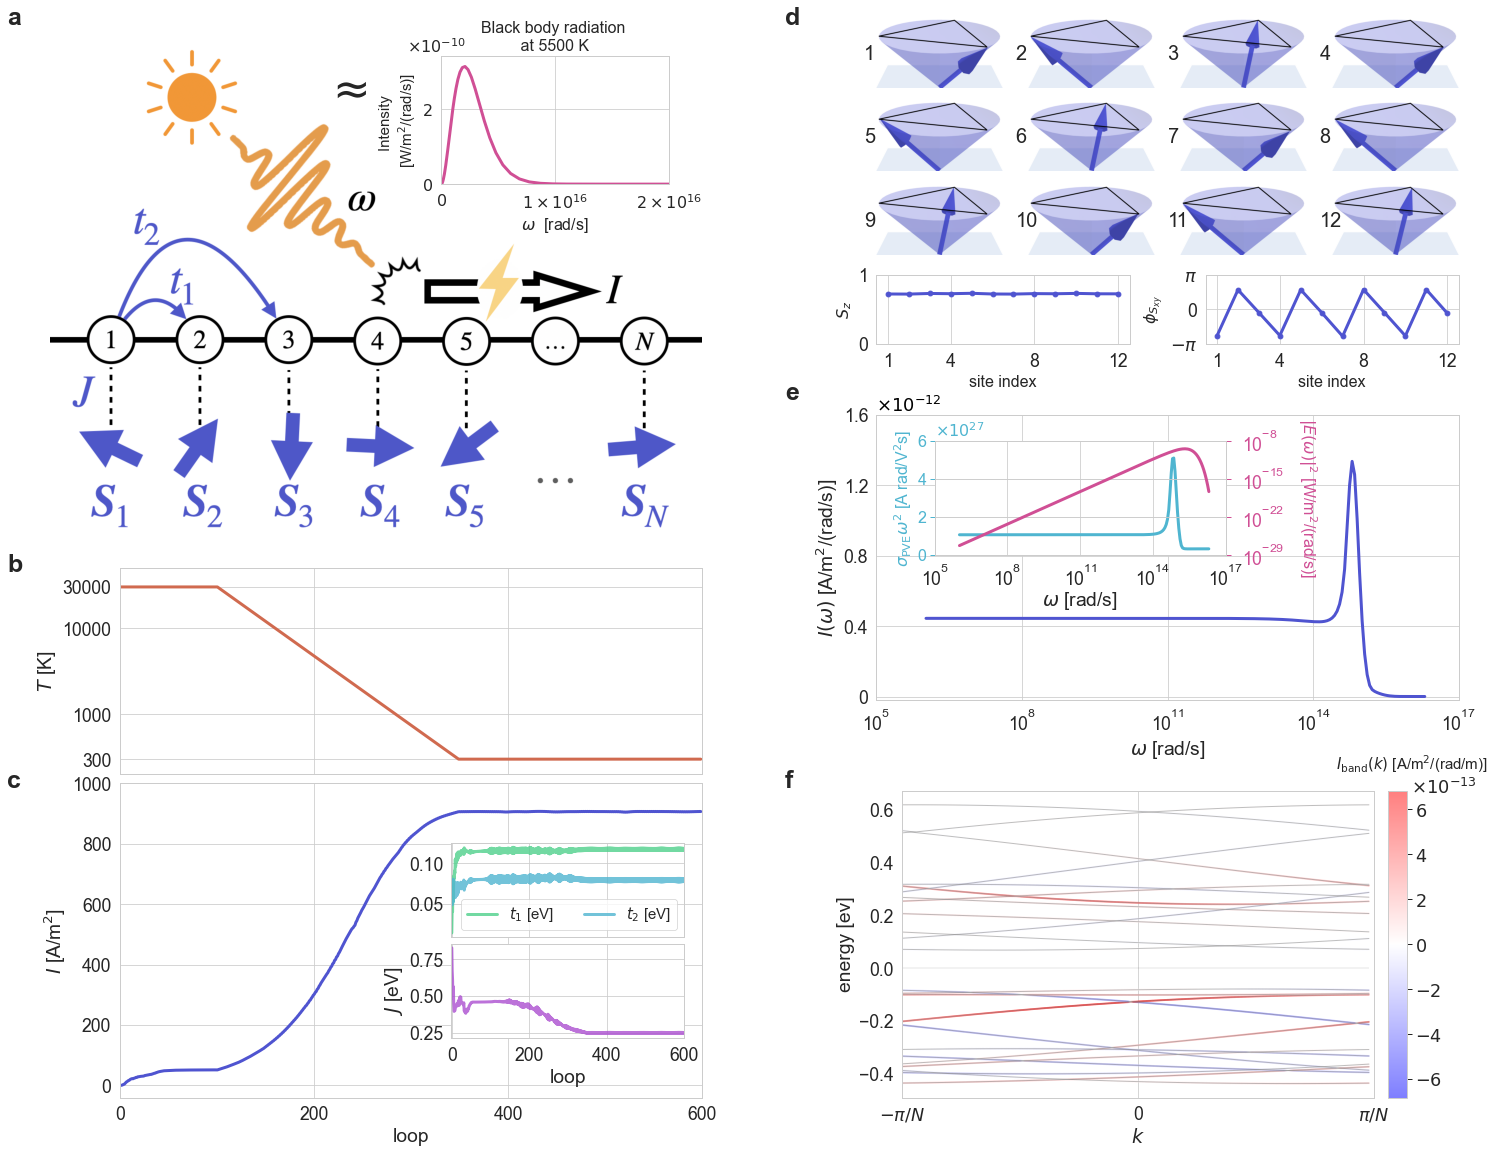

In [95]:
figure = plt.figure(figsize=(24, 20))
gs_master = GridSpec(nrows=20, ncols=2, height_ratios=[1]*20, width_ratios=[1,1], hspace=1.0, wspace=0.3)

cmap = LinearSegmentedColormap.from_list('mycmap', [(0, 'blue'), (0.5, 'gray'),(1.0, 'red')])

_x_fig_ind, _y_fig_ind = -0.20, 1.00

####################################################################################################

gs_1 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[0:10, 0:1])
ax = figure.add_subplot(gs_1[0])

ax.grid(False)
ax.axis("off")
im = plt.imread('../figure/screen_shot.png')
im = im[300:1400,400:1800,:]
im_x, im_y, _ = im.shape
ax.imshow(im)
ax.text(0.42,0.88, r'$\approx$', fontsize=45, transform=ax.transAxes, rotation=0)
box = ax.get_position().get_points()
box_new = box+np.array([[-0.04, -0.04],[0.00,0.01]])
ax.set_position(Bbox(box_new))


axin = ax.inset_axes([0.60, 0.72, 0.35, 0.25]) # [left, bottom, width, height]
fsin = 16
axin.plot(ws, blackbody_rad_modified, c=my_color(2))
axin.set_xlabel(r'$\omega$  [rad/s]', fontsize=fsin)
axin.set_ylabel('Intensity \n' +  r'[W/m$^2$/(rad/s)]', fontsize=15)
axin.set_xticks([0,1e16,2e16])
axin.set_xticklabels([r'$0$', r'$1\times10^{16}$', r'$2\times10^{16}$'], fontsize=fsin)
axin.set_xlim(0,2e16)
axin.set_ylim(0,3.4e-10)
axin.set_yticks([0,2e-10])
axin.set_yticklabels([r'$0$', r'$2$'], fontsize=fsin)
axin.text(-0.3e16,3.5e-10, r'$\times 10^{-10}$', fontsize=fsin)
axin.set_title('Black body radiation \n at 5500 K ', fontsize=fsin)



####################################################################################################
gs_2 = GridSpecFromSubplotSpec(nrows=10, ncols=1, subplot_spec=gs_master[10:20, 0:1])

ax = figure.add_subplot(gs_2[0:4,:])
ax.plot(temperatures, c=my_color(3))
ax.set_xticklabels([])
ax.set_yscale('log')
ax.set_yticks([300,1000,10000, 30000])
ax.set_yticklabels([300,1000,10000, 30000])
ax.set_xlim(-1,600)
ax.set_ylim(200,50000)
ax.set_ylabel(r'$T$ [K]')
ax.tick_params(labelbottom=False)
#ax.text(_x_fig_ind, _y_fig_ind, "b", transform=ax.transAxes, weight='bold', fontsize=25)


ax = figure.add_subplot(gs_2[4:10,:], sharex=ax)
ax.plot(-logger['Current'], c=my_color(0))
ax.set_xlim(-1,600)
ax.set_ylim(-40,1000)
ax.set_ylabel(r'$I$ [A/m$^2$]')
ax.set_xticks([0,200,400,600])
ax.set_xticklabels([0,200,400,600])
ax.set_xlabel('loop')
#ax.text(_x_fig_ind, _y_fig_ind, "c", transform=ax.transAxes, weight='bold', fontsize=25)

fsin = 16
axin = ax.inset_axes([0.57, 0.51, 0.40, 0.30]) # [left, bottom, width, height]
axin.plot(logger['t'][:,0].real/ec, c=my_color(6), label=r'$t_1$ [eV]', alpha=0.8)
axin.plot(logger['t'][:,1].real/ec, c=my_color(7), label=r'$t_2$ [eV]', alpha=0.8)
axin.set_xticks([0,200,400,600])
axin.set_xticklabels([])
axin.legend(loc='lower right', ncol=2, fontsize=15)
axin.set_xlabel('loop')
axin.set_xlim(-1,600)

axin = ax.inset_axes([0.57, 0.19, 0.40, 0.30]) # [left, bottom, width, height]
axin.plot(logger['J_S'][:,0]/ec, c=my_color(1), label=r'$J$', alpha=0.8)
axin.set_xticks([0,200,400,600])
axin.set_xticklabels([0,200,400,600])
#axin.legend(loc='lower right')
axin.set_xlabel('loop')
axin.set_ylabel(r'$J$ [eV]')
axin.set_xlim(-1,600)





####################################################################################################
gs_3 = GridSpecFromSubplotSpec(nrows=3, ncols=4, subplot_spec=gs_master[0:5, 1:2], hspace=0.00)

_i = 0
for _i in range(N):
    ax = figure.add_subplot(gs_3[_i//4,_i%4])
    ax.grid(False)
    ax.axis("off")

    im = plt.imread(f'../figure/spins_{_i}.png')
    #print(im.shape)
    im = im[550:1000,800:1600,:]
    im_x, im_y, _ = im.shape
    ax.imshow(im)
    ax.text(-0.1,0.4,f'{_i+1}', transform=ax.transAxes, fontsize=20)

####################################################################################################
gs_32 = GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=gs_master[5:7, 1:2], wspace=0.30)
fsin = 16
ax = figure.add_subplot(gs_32[0])
ax.plot(np.arange(1,13), hc_modified['Sz'], marker='o', c=my_color(0))
ax.set_ylim(0,1)
ax.set_xticks([1,4,8,12])
#ax.set_xticklabels([3,6,9,12])
ax.set_ylabel(r'$S_z$', fontsize=fsin)
ax.set_xlabel('site index', fontsize=fsin)
box = ax.get_position().get_points()
box_new = box + np.array([[0.0, 0.02],[0,0.01]])
ax.set_position(Bbox(box_new))


ax = figure.add_subplot(gs_32[1])
phi_S = np.arctan2(hc_modified['Sy'], hc_modified['Sx'])
ax.plot(np.arange(1,13), phi_S, marker='o', c=my_color(0))
ax.set_ylim(-np.pi,np.pi)
ax.set_yticks([-np.pi, 0, np.pi])
ax.set_yticklabels([r'$-\pi$', r'0', r'$\pi$'] )
ax.set_ylabel(r'$\phi_{S_{xy}}$', fontsize=fsin)
ax.set_xticks([1,4,8,12])
ax.set_xlabel('site index', fontsize=fsin)
box = ax.get_position().get_points()
box_new = box + np.array([[0.0, 0.02],[0,0.01]])
ax.set_position(Bbox(box_new))



####################################################################################################
gs_4 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[7:13, 1:2], hspace=0.3)

_wmin = 1e5 # 1e5
ax = figure.add_subplot(gs_4[0])
box = ax.get_position().get_points()
box_new = box + np.array([[0.0, 0.005],[0.0, -0.01]])
ax.set_position(Bbox(box_new))


ax.plot(ws, (PVE_1+PVE_2+PVE_3+PVE_4).real*blackbody_rad_modified, c=my_color(0))
ax.set_xscale('log')
ax.set_xlim(_wmin, 1e17)
ax.set_ylim(-0.02e-12, 1.6e-12)
ax.set_xticks([1e5,1e8,1e11,1e14,1e17])
ax.set_yticks([0, 0.4e-12, 0.8e-12, 1.2e-12, 1.6e-12])
ax.set_yticklabels([0, 0.4, 0.8, 1.2, 1.6])
ax.set_xlabel(r'$\omega$ [rad/s]')
ax.set_ylabel(r'$I(\omega)$ [A/m$^2$/(rad/s)]')
ax.text(_wmin, 1.62e-12, r'$\times 10^{-12}$', fontsize=18, c='black')



axin = ax.inset_axes([0.10, 0.51, 0.50, 0.40]) # [left, bottom, width, height]
fsin = 16

axin.plot(ws, (PVE_1+PVE_2+PVE_3+PVE_4).real*ws**2, c=my_color(7))
axin.set_ylabel(r'$\sigma_{\rm PVE} \omega^2$ [A rad/V$^2$s]', c=my_color(7), fontsize=fsin)


axin.set_xscale('log')
axin.set_ylim(0, 6.0e27)
axin.set_yticks([0, 2e27, 4e27, 6e27])
axin.set_yticklabels([0, 2, 4, 6], fontsize=fsin)
axin.tick_params(axis='y', colors=my_color(7)) #ax.spines['left'].set_color('#888888')
axin.set_xlim(_wmin, 1e17)
axin.set_xticks([1e5,1e8,1e11,1e14,1e17])
axin.set_xlabel(r'$\omega$ [rad/s]', labelpad=0)
axin.text(_wmin, 6.2e27, r'$\times 10^{27}$', fontsize=fsin, c=my_color(7))



ax2 = axin.twinx()
ax2.plot(ws, blackbody_rad_modified, c=my_color(2))
ax2.set_ylabel(r'$|E(\omega)|^2$ [W/m$^2$/(rad/s)]', c=my_color(2), rotation=270, labelpad=35, fontsize=fsin)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim(1e-29, 1e-8)
ax2.set_yticks([1e-29,1e-22,1e-15,1e-8])
ax2.tick_params(axis='y', colors=my_color(2)) #ax.spines['left'].set_color('#888888')
ax2.tick_params(axis='y', which='major', pad=11)



####################################################################################################
gs_5 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[14:20, 1:2])

ax = figure.add_subplot(gs_5[0])
box = ax.get_position().get_points()
box_new = box + np.array([[0.015, 0.00],[-0.030, 0.0]])
ax.set_position(Bbox(box_new))

k_roll_interp = np.linspace(k_roll[0], k_roll[-1], 600, endpoint=True)
for i in range(2*N):
    ax.plot(k_roll, (e_roll[:,i]-mu)/ec, color='gray', alpha=0.5, lw=1.0)
    e_roll_interp = np.interp(k_roll_interp, k_roll, (e_roll[:, i]-mu)/ec)
    Current_band_roll_interp = np.interp(k_roll_interp, k_roll, Current_band_roll[:,i])
    mappable =  ax.scatter(k_roll_interp, e_roll_interp, edgecolor='none', c=Current_band_roll_interp, s=4, cmap='bwr', alpha=0.5, vmin=-np.max(np.abs(Current_band))*1.1, vmax=np.max(np.abs(Current_band))*1.1)
ax.hlines(0.0, k_roll[0], k_roll[-1], colors='black', lw=0.1)
ax.set_ylabel('energy [ev]')


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.2)
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_ticks([-6.0e-13, -4.0e-13, -2.0e-13, 0, 2.0e-13, 4.0e-13, 6.0e-13])
cbar.set_ticklabels([r'$-6$', r'$-4$', r'$-2$', r'$0$', r'$2$', r'$4$', r'$6$'])
ax.text(1.08, 0.99, r'$\times 10^{-13}$', transform=ax.transAxes, fontsize=18)
ax.text(0.92, 1.07, r'$I_{\rm band}(k)$ [A/m$^2$/(rad/m)]', transform=ax.transAxes, fontsize=15)

ax.set_xlabel(r'$k$')
ax.set_xlim(-K/2, K/2)
ax.set_xticks([-K/2,0, K/2])
ax.set_xticklabels([r'$-\pi/N$', '0', r'$\pi/N$'])
ax.yaxis.grid(False)



plt.text(0.06, 0.87, r'a', transform=figure.transFigure, weight='bold', fontsize=25)
plt.text(0.06, 0.49, r'b', transform=figure.transFigure, weight='bold', fontsize=25)
plt.text(0.06, 0.34, r'c', transform=figure.transFigure, weight='bold', fontsize=25)

plt.text(0.51, 0.87, r'd', transform=figure.transFigure, weight='bold', fontsize=25)
plt.text(0.51, 0.61, r'e', transform=figure.transFigure, weight='bold', fontsize=25)
plt.text(0.51, 0.34, r'f', transform=figure.transFigure, weight='bold', fontsize=25)


figure.savefig("../figure/photovoltaic.pdf", format='pdf')
plt.show()

## supplementary

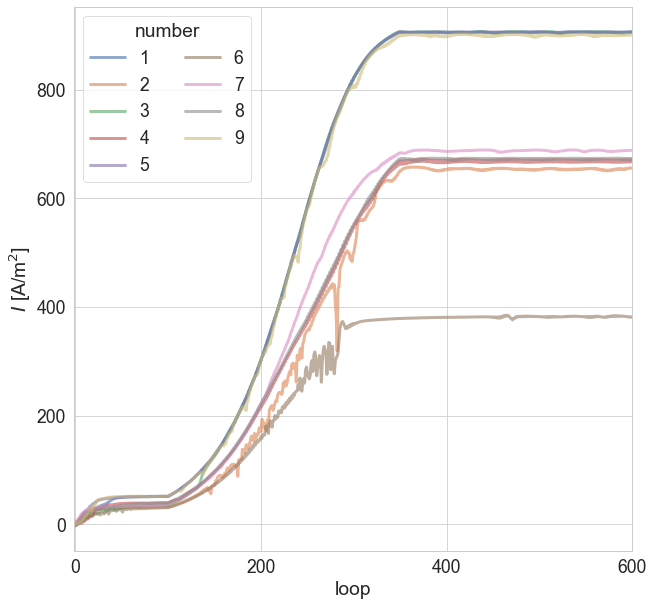

In [42]:
_,_, get_params = optimizers.rmsprop(0.1, gamma=0.99)
step_init = 0

num_steps = 600
xs = {'step': step_init + jnp.arange(num_steps)}
temperatures = jnp.concatenate([jnp.array([30000]*100), jnp.geomspace(30000, 300, num_steps-350), jnp.array([300]*250)])
taus = jnp.array([1e-13]*num_steps)
xs['beta'] = jnp.array(1.0/temperatures)/k_b # 室温
xs['gamma'] = 2*jnp.pi/(taus)


fig, ax = plt.subplots(figsize=(10,10))
for seed in range(1,10):
    opt_state, logger = load_results('pve',seed) 
    params = get_params(opt_state)
    ax.plot(-logger['Current'], alpha=0.6, label=f'{seed}')

ax.set_xlim(-1,600)
ax.set_ylabel(r'$I$ [A/m$^2$]')
ax.set_xticks([0,200,400,600])
ax.set_xticklabels([0,200,400,600])
ax.set_xlabel('loop')

ax.legend(ncol=2, loc='upper left', title='number')

fig.savefig("../figure/sup_pve_current.pdf", format='pdf')
plt.show()

In [43]:
_,_, get_params = optimizers.rmsprop(0.1, gamma=0.99)
step_init = 0

opt_state, logger = load_results('pve',1) 
params = get_params(opt_state)

num_steps = 600
xs = {'step': step_init + jnp.arange(num_steps)}
temperatures = jnp.concatenate([jnp.array([30000]*100), jnp.geomspace(30000, 300, num_steps-350), jnp.array([300]*250)])
taus = jnp.array([1e-13]*num_steps)
xs['beta'] = jnp.array(1.0/temperatures)/k_b # 室温
xs['gamma'] = 2*jnp.pi/(taus)

beta, temperature, tau, gamma = xs['beta'][-1], temperatures[-1], taus[-1], xs['gamma'][-1]

filling = jnp.array(12.0)

hc, e, v, mu, ws, PVE_1, PVE_2, PVE_3, PVE_4, Current, S_modified = calc_results(params, k, ws, beta, filling, gamma, blackbody_rad_modified, hc_cond)

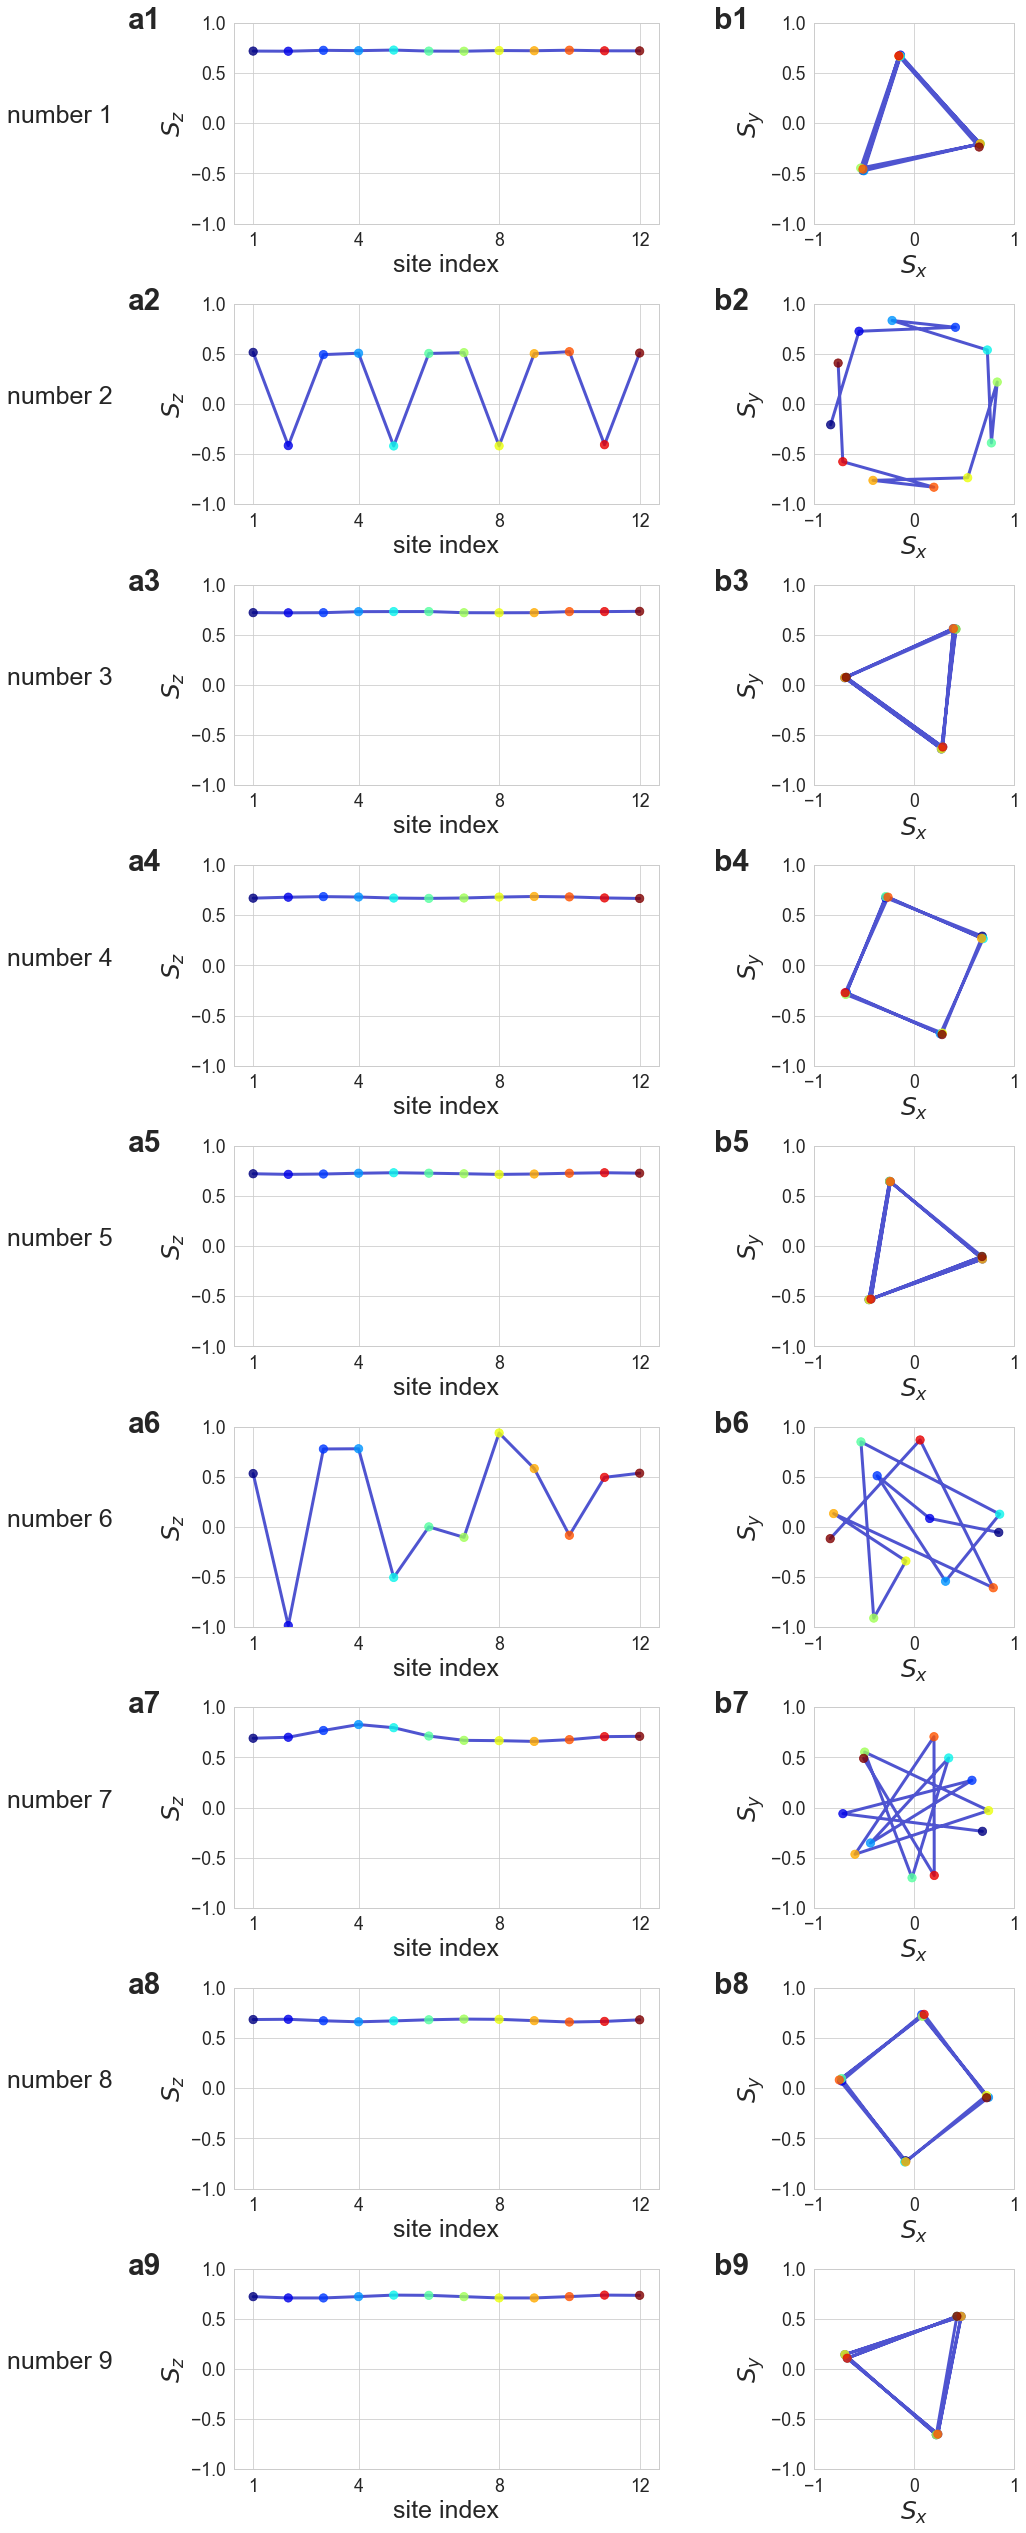

In [60]:
fig, axes = plt.subplots(figsize=(16,5*9), nrows=9, ncols=2)
fig.subplots_adjust(hspace=0.4, wspace=0.1)

_fsize = 30
_fsizes = 25
_fsizet = 22

for seed in range(1,10):
    _,_, get_params = optimizers.rmsprop(0.1, gamma=0.99)
    step_init = 0

    opt_state, logger = load_results('pve',seed) 
    params = get_params(opt_state)

    num_steps = 600
    xs = {'step': step_init + jnp.arange(num_steps)}
    temperatures = jnp.concatenate([jnp.array([30000]*100), jnp.geomspace(30000, 300, num_steps-350), jnp.array([300]*250)])
    taus = jnp.array([1e-13]*num_steps)
    xs['beta'] = jnp.array(1.0/temperatures)/k_b # 室温
    xs['gamma'] = 2*jnp.pi/(taus)

    beta, temperature, tau, gamma = xs['beta'][-1], temperatures[-1], taus[-1], xs['gamma'][-1]

    filling = jnp.array(12.0)

    hc, e, v, mu, ws, PVE_1, PVE_2, PVE_3, PVE_4, Current, S_modified = calc_results(params, k, ws, beta, filling, gamma, blackbody_rad_modified, hc_cond)
    S_modified = rotate_S(hc)
    hc_modified = copy.deepcopy(hc)
    hc_modified['Sx'] = S_modified[:,0]
    hc_modified['Sy'] = S_modified[:,1]
    hc_modified['Sz'] = S_modified[:,2]


    ax = axes[seed-1, 0]
    ax.plot(np.arange(1,13), hc_modified['Sz'], c=my_color(0), zorder=1)
    ax.scatter(np.arange(1,13), hc_modified['Sz'], c=jnp.arange(N), cmap='jet', alpha=0.8, s = 70, zorder=2)
    ax.set_ylim(-1,1)
    ax.set_xticks([1,4,8,12])
    ax.set_ylabel(r'$S_z$', fontsize=_fsizes)
    ax.set_xlabel('site index', fontsize=_fsizes)
    ax.text(-0.25, 0.97, f"a{seed}", transform=ax.transAxes, weight='bold', fontsize=_fsize)
    ax.text(-6, 0.00, f"number {seed}", fontsize=_fsizes)

    

    ax = axes[seed-1, 1]
    ax.plot(hc_modified['Sx'], hc_modified['Sy'], c=my_color(0), zorder=1)
    ax.scatter(hc_modified['Sx'], hc_modified['Sy'], c=jnp.arange(N), cmap='jet', alpha=0.8, s = 70, zorder=2)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xlabel(r'$S_x$', fontsize=_fsizes)
    ax.set_ylabel(r'$S_y$', fontsize=_fsizes)
    ax.set_aspect('equal')
    ax.text(-0.50, 0.97, f"b{seed}", transform=ax.transAxes, weight='bold', fontsize=_fsize)


fig.savefig("../figure/sup_pve_spins.pdf", format='pdf', bbox_inches='tight')
plt.show()

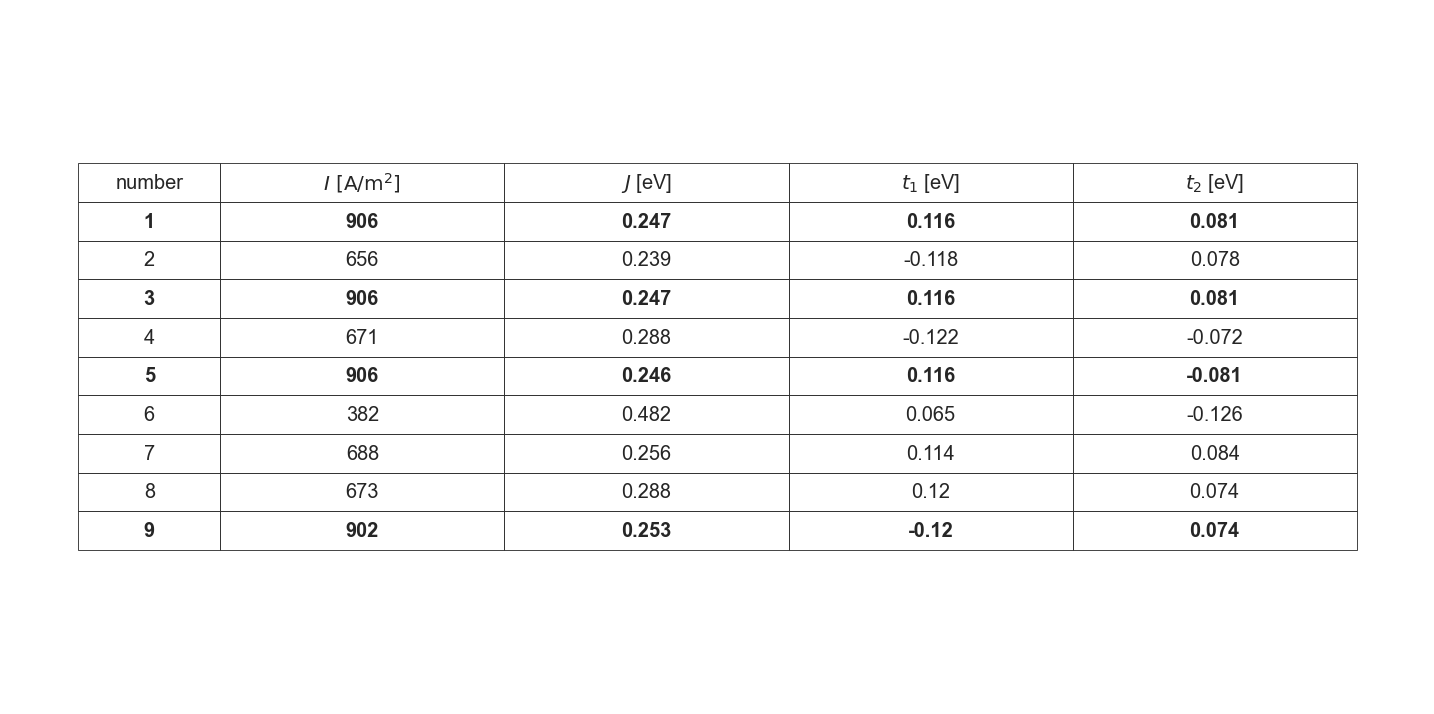

In [82]:
from matplotlib.font_manager import FontProperties
fig, ax = plt.subplots(figsize=(20,10), nrows=1, ncols=1)

collabels = ['number', r'$I ~{\rm [A/m^2] }$', r'$J$ [eV]', r'$t_1$ [eV]', r'$t_2$ [eV]']
data_seeds  = [1,2,3,4,5,6,7,8,9]
list_data = []

for seed in data_seeds:
    _,_, get_params = optimizers.rmsprop(0.1, gamma=0.99)
    step_init = 0

    opt_state, logger = load_results('pve',seed) 
    list_data.append([seed, -int(logger['Current'][-1].item()), np.round(logger['J_S'][-1].item()/ec,3) , 
                      np.round(logger['t'][-1, 0].real.item()/ec, 3), np.round(logger['t'][-1, 1].real.item()/ec, 3)])
    
table = ax.table(cellText=list_data, colLabels=collabels, loc='center', cellLoc='center', colWidths = [0.1,0.2,0.2,0.2,0.2])

for (row, col), cell in table.get_celld().items():
    if (row in [1,3,5,9]):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))
table.auto_set_font_size(False)
table.set_fontsize(20)
table.scale(1.0, 2.5) 


ax.axis('off')

fig.tight_layout()

#fig.savefig("../figure/sup_pve_table.pdf", format='pdf')
plt.show()